In [1]:
from __future__ import print_function
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from torch import optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import mean_squared_error

from model.model_v2_EWA import spk_vq_vae_resnet
from model.utils import Helper

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# %% parameters passed to data loader
import collections
args = collections.namedtuple

# args.train_data_path = './data/wave_clus_noise01_c4.mat'
# args.test_data_path = './data/wave_clus_noise01_c4.mat'

# args.train_data_path = './data/hc1.mat'
# args.test_data_path = './data/hc1.mat'

# args.train_data_path = './data/C_drift.mat'
# args.test_data_path = './data/C_drift.mat'

# args.train_data_path = './data/pac_scream70dB_spks_3d.mat'
# args.test_data_path = './data/pac_scream70dB_spks_3d.mat'

args.train_data_path = '../DeepVAE_data/C_difficult1_spks_c4.mat'
args.test_data_path = '../DeepVAE_data/C_difficult1_spks_c4.mat'

# args.train_data_path = './data/C_easy1_spks_c4.mat'
# args.test_data_path = './data/C_easy1_spks_c4.mat'

# args.train_data_path = '../DeepVAE_data/Neuropixels_spks_c4.mat'
# args.test_data_path = '../DeepVAE_data/Neuropixels_spks_c4.mat'

args.train_ratio = .6
args.test_ratio = .4
args.seed = 1
args.batch_size = 48
args.test_batch_size = 128
args.randperm = True

if args.train_data_path is not args.test_data_path:
    args.val_norm = True
else:
    args.val_norm = False

# %% global parameters
spk_ch = 4
args.spk_ch = spk_ch
spk_dim = 64
log_interval = 50
beta = 0.15
vq_num = 128

"""
org_dim     = param[0]
conv1_ch    = param[1]
conv2_ch    = param[2]
conv1_ker   = param[4]
conv2_ker   = param[5]
self.vq_dim = param[6]
self.vq_num = param[7]
cardinality = param[8]
vq on chan  = param[9]
"""
param_resnet_v2 = [spk_ch, 256, 16, 1, 3, 1, int(spk_dim/4), vq_num, 16, 4, False, 0.2]

# %% train/test splitting and normalization
helper = Helper(args)
train_loader, test_loader = helper.create_data_loaders()

In [3]:
# %%
model = spk_vq_vae_resnet(param_resnet_v2).to(gpu)
#summary(model, (spk_ch, spk_dim))
#model.load_state_dict(torch.load('./cae_models/spk_vq_vae_hc1_vq{}_N{}.pt'.format(vq_num, param_resnet_v2[2])))

In [4]:
# %%
def loss_function(recon_x, x, commit_loss):
    recon_loss = F.mse_loss(recon_x, x, size_average=False)
    return recon_loss + beta * commit_loss, recon_loss
    #return recon_loss + vq_loss, recon_loss

In [5]:
# %%
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4, amsgrad=True)
#optimizer = optim.SGD(model.parameters(), lr=1e-6, weight_decay=1e-5, momentum=0.9)
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-6)
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=.9)

# decay_embed, decay_rest = [], []
# for name, param in model.named_parameters():
#     if 'embed' in name:
#         decay_embed.append(param)
#     else:
#         decay_rest.append(param)

# optimizer = optim.SGD([
#     {'params': decay_rest, 'weight_decay':1e-4},
#     {'params': decay_embed, 'weight_decay':1e-5, 'momentum':0.9}
#     ], lr=1e-9, momentum=0.9)

# scheduler = MultiStepLR(optimizer, milestones=[250,350,600], gamma=0.1)

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        #data = Variable(data).cuda()
        data = data.to(gpu)

        optimizer.zero_grad()
        recon_batch, commit_loss = model(data)
        loss, recon_loss = loss_function(recon_batch, data, commit_loss)
        loss.backward(retain_graph=True)
        model.bwd()
        optimizer.step()
        
        #train_loss += recon_loss.data[0] * len(data)
        train_loss += recon_loss.item() / (spk_dim * spk_ch)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), recon_loss.item()))

    #print(model.embed.weight.data)
    
    average_train_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average train loss: {:.5f}'.format(
          epoch, average_train_loss))
    return average_train_loss

In [7]:
# %% save model
best_val_loss = 10 # v3
cur_train_loss = 1
#best_val_loss = .3965 # v1
def save_model(val_loss, train_loss):
	global best_val_loss, cur_train_loss
	if val_loss < best_val_loss:
		best_val_loss = val_loss
		cur_train_loss = train_loss
		torch.save(model.state_dict(), './spk_vq_vae_temp.pt')

In [8]:
# %%
def test(epoch):
    model.eval()
    model.embed_reset()
    test_loss = 0
    recon_sig = torch.rand(1, spk_ch, spk_dim)
    org_sig = torch.rand(1, spk_ch, spk_dim)
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            data = data.to(gpu)

            recon_batch, commit_loss = model(data)
            _, recon_loss = loss_function(recon_batch, data, commit_loss)
        
            recon_sig = torch.cat((recon_sig, recon_batch.data.cpu()), dim=0)
            org_sig = torch.cat((org_sig, data.data.cpu()), dim=0)
        
            #test_loss += recon_loss.data[0] * len(data)
            test_loss += recon_loss.item() / (spk_dim * spk_ch)

        average_test_loss = test_loss / len(test_loader.dataset)
        print('====> Epoch: {} Average test loss: {:.5f}'.format(
              epoch, average_test_loss))

    if epoch % 10 == 0:
        plt.figure(figsize=(15,5))
        plt.bar(np.arange(vq_num), model.embed_freq / model.embed_freq.sum())
        plt.show()

    return average_test_loss, recon_sig[1:], org_sig[1:]

In [9]:
# def test_batch():
# 	model.eval()
# 	_, _, data = helper.param_for_recon()
# 	data = Variable(torch.from_numpy(data)).cuda()
# 	results, commit_loss = model(data)
# 	_, recon_loss = loss_function(results, data, commit_loss)
# 	print('Average test loss: {:.4f}'.format(recon_loss.data[0]))
# 	return recon_loss, results

In [10]:
# %% training and validating
train_loss_history = []
test_loss_history = []

Train Epoch: 1 [0/2057 (0%)]	Loss: 15415.4883
====> Epoch: 1 Average train loss: 0.62051
====> Epoch: 1 Average test loss: 0.65190
Train Epoch: 2 [0/2057 (0%)]	Loss: 7499.4375
====> Epoch: 2 Average train loss: 0.58934
====> Epoch: 2 Average test loss: 0.61397
Train Epoch: 3 [0/2057 (0%)]	Loss: 7364.5156
====> Epoch: 3 Average train loss: 0.56772
====> Epoch: 3 Average test loss: 0.59269
Train Epoch: 4 [0/2057 (0%)]	Loss: 6962.5010
====> Epoch: 4 Average train loss: 0.54244
====> Epoch: 4 Average test loss: 0.56308
Train Epoch: 5 [0/2057 (0%)]	Loss: 6552.6475
====> Epoch: 5 Average train loss: 0.51618
====> Epoch: 5 Average test loss: 0.53488
Train Epoch: 6 [0/2057 (0%)]	Loss: 5894.0308
====> Epoch: 6 Average train loss: 0.49983
====> Epoch: 6 Average test loss: 0.51321
Train Epoch: 7 [0/2057 (0%)]	Loss: 6327.5039
====> Epoch: 7 Average train loss: 0.47612
====> Epoch: 7 Average test loss: 0.49622
Train Epoch: 8 [0/2057 (0%)]	Loss: 5948.4517
====> Epoch: 8 Average train loss: 0.45818
=

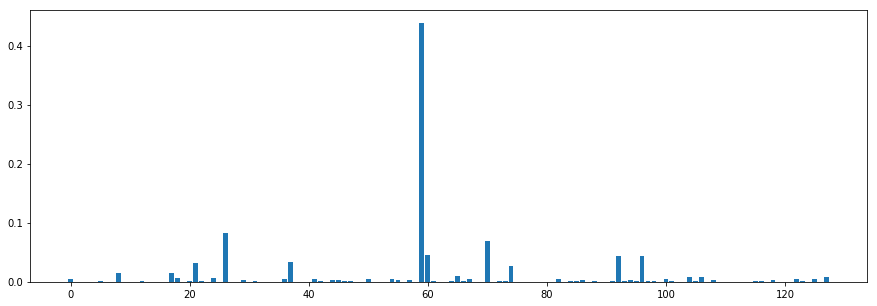

Train Epoch: 11 [0/2057 (0%)]	Loss: 4911.9409
====> Epoch: 11 Average train loss: 0.41135
====> Epoch: 11 Average test loss: 0.39808
Train Epoch: 12 [0/2057 (0%)]	Loss: 4959.7578
====> Epoch: 12 Average train loss: 0.40265
====> Epoch: 12 Average test loss: 0.38874
Train Epoch: 13 [0/2057 (0%)]	Loss: 4833.6636
====> Epoch: 13 Average train loss: 0.39092
====> Epoch: 13 Average test loss: 0.37400
Train Epoch: 14 [0/2057 (0%)]	Loss: 4125.2842
====> Epoch: 14 Average train loss: 0.38080
====> Epoch: 14 Average test loss: 0.36482
Train Epoch: 15 [0/2057 (0%)]	Loss: 4377.2725
====> Epoch: 15 Average train loss: 0.37435
====> Epoch: 15 Average test loss: 0.35760
Train Epoch: 16 [0/2057 (0%)]	Loss: 4917.3447
====> Epoch: 16 Average train loss: 0.36567
====> Epoch: 16 Average test loss: 0.35011
Train Epoch: 17 [0/2057 (0%)]	Loss: 5145.6187
====> Epoch: 17 Average train loss: 0.36406
====> Epoch: 17 Average test loss: 0.35154
Train Epoch: 18 [0/2057 (0%)]	Loss: 4494.8413
====> Epoch: 18 Average

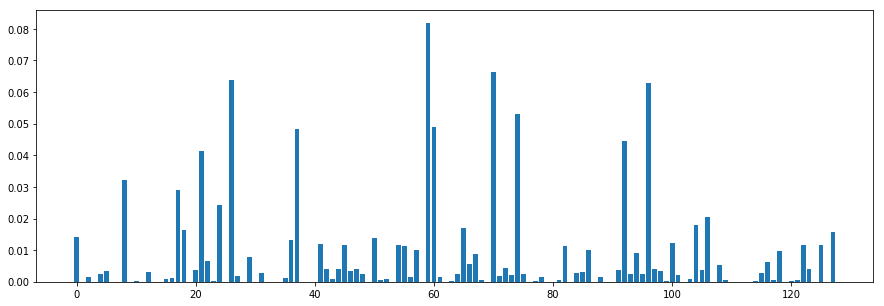

Train Epoch: 21 [0/2057 (0%)]	Loss: 4123.5723
====> Epoch: 21 Average train loss: 0.34425
====> Epoch: 21 Average test loss: 0.32733
Train Epoch: 22 [0/2057 (0%)]	Loss: 4424.2695
====> Epoch: 22 Average train loss: 0.34236
====> Epoch: 22 Average test loss: 0.32566
Train Epoch: 23 [0/2057 (0%)]	Loss: 4060.5940
====> Epoch: 23 Average train loss: 0.34125
====> Epoch: 23 Average test loss: 0.30844
Train Epoch: 24 [0/2057 (0%)]	Loss: 4166.8716
====> Epoch: 24 Average train loss: 0.33579
====> Epoch: 24 Average test loss: 0.31053
Train Epoch: 25 [0/2057 (0%)]	Loss: 4258.7974
====> Epoch: 25 Average train loss: 0.33294
====> Epoch: 25 Average test loss: 0.30923
Train Epoch: 26 [0/2057 (0%)]	Loss: 3974.9880
====> Epoch: 26 Average train loss: 0.33184
====> Epoch: 26 Average test loss: 0.30246
Train Epoch: 27 [0/2057 (0%)]	Loss: 3746.4470
====> Epoch: 27 Average train loss: 0.32553
====> Epoch: 27 Average test loss: 0.29269
Train Epoch: 28 [0/2057 (0%)]	Loss: 4179.7891
====> Epoch: 28 Average

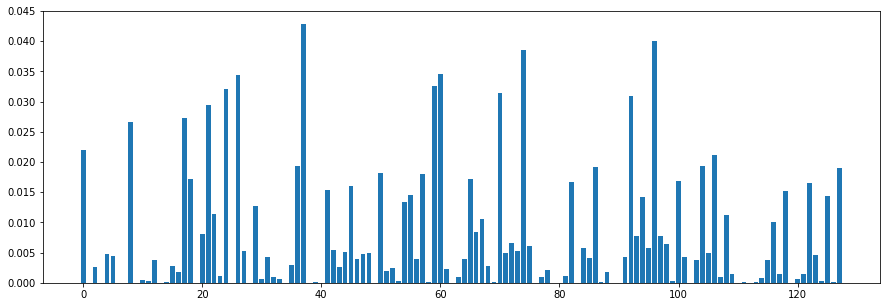

Train Epoch: 31 [0/2057 (0%)]	Loss: 4078.6941
====> Epoch: 31 Average train loss: 0.32169
====> Epoch: 31 Average test loss: 0.28198
Train Epoch: 32 [0/2057 (0%)]	Loss: 3897.5845
====> Epoch: 32 Average train loss: 0.32023
====> Epoch: 32 Average test loss: 0.28888
Train Epoch: 33 [0/2057 (0%)]	Loss: 3495.7161
====> Epoch: 33 Average train loss: 0.31554
====> Epoch: 33 Average test loss: 0.28167
Train Epoch: 34 [0/2057 (0%)]	Loss: 4014.5481
====> Epoch: 34 Average train loss: 0.31590
====> Epoch: 34 Average test loss: 0.27688
Train Epoch: 35 [0/2057 (0%)]	Loss: 3495.5208
====> Epoch: 35 Average train loss: 0.31495
====> Epoch: 35 Average test loss: 0.28480
Train Epoch: 36 [0/2057 (0%)]	Loss: 3944.5037
====> Epoch: 36 Average train loss: 0.31279
====> Epoch: 36 Average test loss: 0.27787
Train Epoch: 37 [0/2057 (0%)]	Loss: 3826.7427
====> Epoch: 37 Average train loss: 0.31221
====> Epoch: 37 Average test loss: 0.27748
Train Epoch: 38 [0/2057 (0%)]	Loss: 3556.7380
====> Epoch: 38 Average

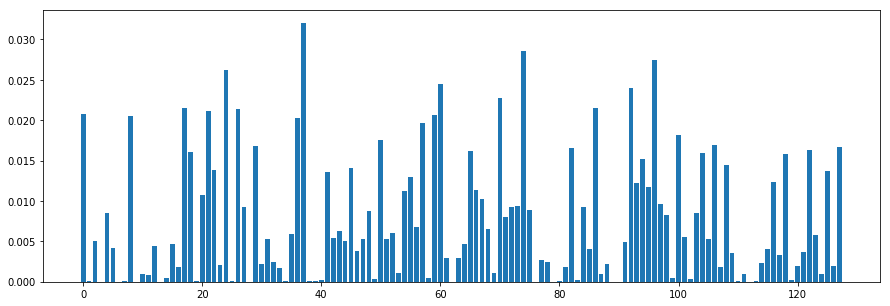

Train Epoch: 41 [0/2057 (0%)]	Loss: 3602.2812
====> Epoch: 41 Average train loss: 0.30677
====> Epoch: 41 Average test loss: 0.26622
Train Epoch: 42 [0/2057 (0%)]	Loss: 3935.8394
====> Epoch: 42 Average train loss: 0.30409
====> Epoch: 42 Average test loss: 0.26661
Train Epoch: 43 [0/2057 (0%)]	Loss: 3338.7556
====> Epoch: 43 Average train loss: 0.30390
====> Epoch: 43 Average test loss: 0.26181
Train Epoch: 44 [0/2057 (0%)]	Loss: 3604.2559
====> Epoch: 44 Average train loss: 0.29978
====> Epoch: 44 Average test loss: 0.26475
Train Epoch: 45 [0/2057 (0%)]	Loss: 3671.6416
====> Epoch: 45 Average train loss: 0.29900
====> Epoch: 45 Average test loss: 0.26673
Train Epoch: 46 [0/2057 (0%)]	Loss: 3424.3804
====> Epoch: 46 Average train loss: 0.30067
====> Epoch: 46 Average test loss: 0.25804
Train Epoch: 47 [0/2057 (0%)]	Loss: 3421.1672
====> Epoch: 47 Average train loss: 0.29946
====> Epoch: 47 Average test loss: 0.25900
Train Epoch: 48 [0/2057 (0%)]	Loss: 3789.4531
====> Epoch: 48 Average

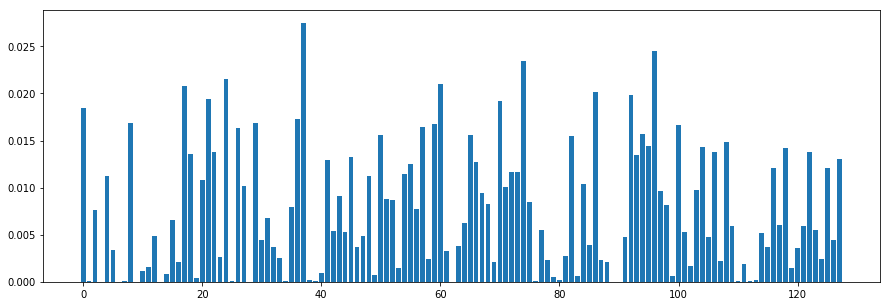

Train Epoch: 51 [0/2057 (0%)]	Loss: 3599.1672
====> Epoch: 51 Average train loss: 0.29545
====> Epoch: 51 Average test loss: 0.25404
Train Epoch: 52 [0/2057 (0%)]	Loss: 3383.2412
====> Epoch: 52 Average train loss: 0.29149
====> Epoch: 52 Average test loss: 0.25699
Train Epoch: 53 [0/2057 (0%)]	Loss: 3467.4448
====> Epoch: 53 Average train loss: 0.29483
====> Epoch: 53 Average test loss: 0.25605
Train Epoch: 54 [0/2057 (0%)]	Loss: 3372.6885
====> Epoch: 54 Average train loss: 0.29303
====> Epoch: 54 Average test loss: 0.25354
Train Epoch: 55 [0/2057 (0%)]	Loss: 3427.6167
====> Epoch: 55 Average train loss: 0.29386
====> Epoch: 55 Average test loss: 0.24714
Train Epoch: 56 [0/2057 (0%)]	Loss: 4570.1729
====> Epoch: 56 Average train loss: 0.29059
====> Epoch: 56 Average test loss: 0.24701
Train Epoch: 57 [0/2057 (0%)]	Loss: 3732.2153
====> Epoch: 57 Average train loss: 0.28898
====> Epoch: 57 Average test loss: 0.24876
Train Epoch: 58 [0/2057 (0%)]	Loss: 3523.7339
====> Epoch: 58 Average

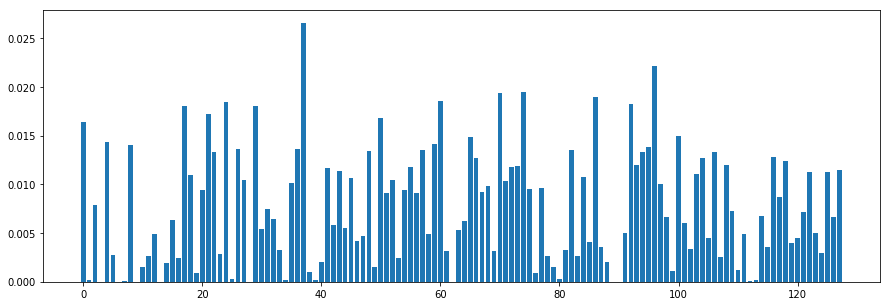

Train Epoch: 61 [0/2057 (0%)]	Loss: 3324.4119
====> Epoch: 61 Average train loss: 0.28650
====> Epoch: 61 Average test loss: 0.24684
Train Epoch: 62 [0/2057 (0%)]	Loss: 3271.5417
====> Epoch: 62 Average train loss: 0.28585
====> Epoch: 62 Average test loss: 0.24964
Train Epoch: 63 [0/2057 (0%)]	Loss: 3737.8552
====> Epoch: 63 Average train loss: 0.28592
====> Epoch: 63 Average test loss: 0.23854
Train Epoch: 64 [0/2057 (0%)]	Loss: 3654.2930
====> Epoch: 64 Average train loss: 0.28233
====> Epoch: 64 Average test loss: 0.24474
Train Epoch: 65 [0/2057 (0%)]	Loss: 3147.1062
====> Epoch: 65 Average train loss: 0.28597
====> Epoch: 65 Average test loss: 0.25144
Train Epoch: 66 [0/2057 (0%)]	Loss: 3561.6589
====> Epoch: 66 Average train loss: 0.28402
====> Epoch: 66 Average test loss: 0.24646
Train Epoch: 67 [0/2057 (0%)]	Loss: 3658.7896
====> Epoch: 67 Average train loss: 0.28408
====> Epoch: 67 Average test loss: 0.23995
Train Epoch: 68 [0/2057 (0%)]	Loss: 3487.6406
====> Epoch: 68 Average

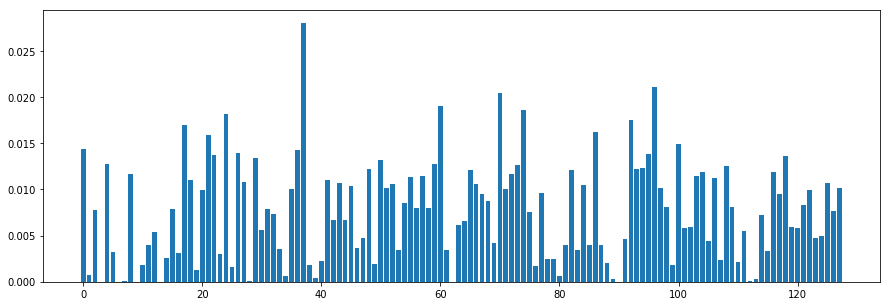

Train Epoch: 71 [0/2057 (0%)]	Loss: 3626.6511
====> Epoch: 71 Average train loss: 0.27917
====> Epoch: 71 Average test loss: 0.23619
Train Epoch: 72 [0/2057 (0%)]	Loss: 3390.8779
====> Epoch: 72 Average train loss: 0.28026
====> Epoch: 72 Average test loss: 0.23509
Train Epoch: 73 [0/2057 (0%)]	Loss: 3365.9956
====> Epoch: 73 Average train loss: 0.28063
====> Epoch: 73 Average test loss: 0.24906
Train Epoch: 74 [0/2057 (0%)]	Loss: 3228.5986
====> Epoch: 74 Average train loss: 0.27938
====> Epoch: 74 Average test loss: 0.24592
Train Epoch: 75 [0/2057 (0%)]	Loss: 3510.5806
====> Epoch: 75 Average train loss: 0.28205
====> Epoch: 75 Average test loss: 0.23759
Train Epoch: 76 [0/2057 (0%)]	Loss: 3081.0046
====> Epoch: 76 Average train loss: 0.28049
====> Epoch: 76 Average test loss: 0.23728
Train Epoch: 77 [0/2057 (0%)]	Loss: 3395.8301
====> Epoch: 77 Average train loss: 0.27913
====> Epoch: 77 Average test loss: 0.23803
Train Epoch: 78 [0/2057 (0%)]	Loss: 3451.3274
====> Epoch: 78 Average

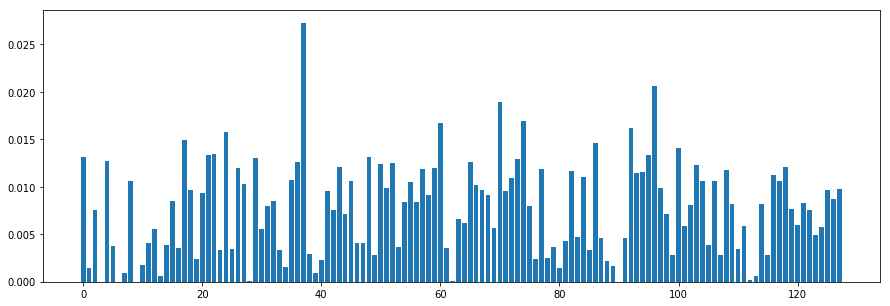

Train Epoch: 81 [0/2057 (0%)]	Loss: 3435.8005
====> Epoch: 81 Average train loss: 0.27821
====> Epoch: 81 Average test loss: 0.23589
Train Epoch: 82 [0/2057 (0%)]	Loss: 3393.2427
====> Epoch: 82 Average train loss: 0.27914
====> Epoch: 82 Average test loss: 0.23003
Train Epoch: 83 [0/2057 (0%)]	Loss: 3095.5947
====> Epoch: 83 Average train loss: 0.27433
====> Epoch: 83 Average test loss: 0.23691
Train Epoch: 84 [0/2057 (0%)]	Loss: 3423.7568
====> Epoch: 84 Average train loss: 0.27481
====> Epoch: 84 Average test loss: 0.24098
Train Epoch: 85 [0/2057 (0%)]	Loss: 3049.6343
====> Epoch: 85 Average train loss: 0.27452
====> Epoch: 85 Average test loss: 0.23387
Train Epoch: 86 [0/2057 (0%)]	Loss: 3579.7732
====> Epoch: 86 Average train loss: 0.27487
====> Epoch: 86 Average test loss: 0.23390
Train Epoch: 87 [0/2057 (0%)]	Loss: 3236.5015
====> Epoch: 87 Average train loss: 0.27204
====> Epoch: 87 Average test loss: 0.23233
Train Epoch: 88 [0/2057 (0%)]	Loss: 2841.5337
====> Epoch: 88 Average

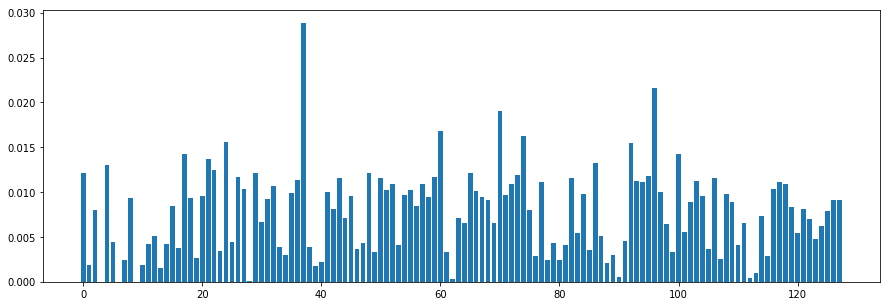

Train Epoch: 91 [0/2057 (0%)]	Loss: 3341.7295
====> Epoch: 91 Average train loss: 0.27465
====> Epoch: 91 Average test loss: 0.23205
Train Epoch: 92 [0/2057 (0%)]	Loss: 3259.4021
====> Epoch: 92 Average train loss: 0.27347
====> Epoch: 92 Average test loss: 0.23339
Train Epoch: 93 [0/2057 (0%)]	Loss: 3141.5122
====> Epoch: 93 Average train loss: 0.27265
====> Epoch: 93 Average test loss: 0.23423
Train Epoch: 94 [0/2057 (0%)]	Loss: 3601.1899
====> Epoch: 94 Average train loss: 0.27358
====> Epoch: 94 Average test loss: 0.23060
Train Epoch: 95 [0/2057 (0%)]	Loss: 3371.4858
====> Epoch: 95 Average train loss: 0.27243
====> Epoch: 95 Average test loss: 0.22974
Train Epoch: 96 [0/2057 (0%)]	Loss: 3116.8003
====> Epoch: 96 Average train loss: 0.27018
====> Epoch: 96 Average test loss: 0.22906
Train Epoch: 97 [0/2057 (0%)]	Loss: 3266.5940
====> Epoch: 97 Average train loss: 0.27080
====> Epoch: 97 Average test loss: 0.23086
Train Epoch: 98 [0/2057 (0%)]	Loss: 3477.8816
====> Epoch: 98 Average

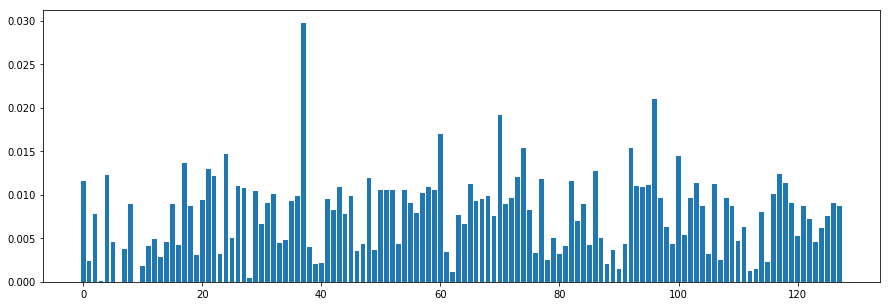

Train Epoch: 101 [0/2057 (0%)]	Loss: 3219.7385
====> Epoch: 101 Average train loss: 0.27246
====> Epoch: 101 Average test loss: 0.22809
Train Epoch: 102 [0/2057 (0%)]	Loss: 3505.0369
====> Epoch: 102 Average train loss: 0.27110
====> Epoch: 102 Average test loss: 0.22702
Train Epoch: 103 [0/2057 (0%)]	Loss: 3024.9958
====> Epoch: 103 Average train loss: 0.27118
====> Epoch: 103 Average test loss: 0.22779
Train Epoch: 104 [0/2057 (0%)]	Loss: 3336.9917
====> Epoch: 104 Average train loss: 0.27132
====> Epoch: 104 Average test loss: 0.22689
Train Epoch: 105 [0/2057 (0%)]	Loss: 3320.0957
====> Epoch: 105 Average train loss: 0.26892
====> Epoch: 105 Average test loss: 0.22424
Train Epoch: 106 [0/2057 (0%)]	Loss: 3580.9885
====> Epoch: 106 Average train loss: 0.26974
====> Epoch: 106 Average test loss: 0.22894
Train Epoch: 107 [0/2057 (0%)]	Loss: 3296.6260
====> Epoch: 107 Average train loss: 0.26992
====> Epoch: 107 Average test loss: 0.22839
Train Epoch: 108 [0/2057 (0%)]	Loss: 3471.8496
=

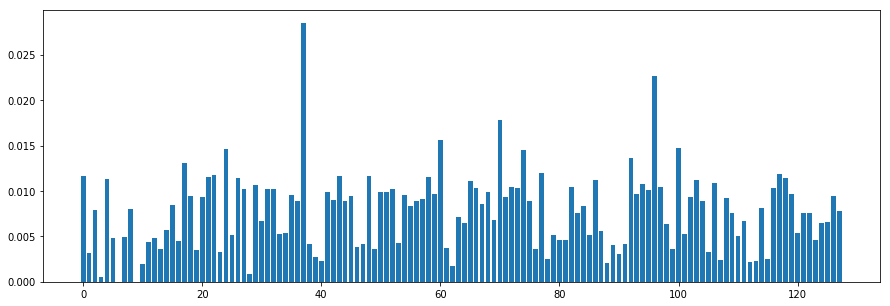

Train Epoch: 111 [0/2057 (0%)]	Loss: 3998.5671
====> Epoch: 111 Average train loss: 0.27028
====> Epoch: 111 Average test loss: 0.22312
Train Epoch: 112 [0/2057 (0%)]	Loss: 3154.1316
====> Epoch: 112 Average train loss: 0.26819
====> Epoch: 112 Average test loss: 0.22449
Train Epoch: 113 [0/2057 (0%)]	Loss: 3188.4229
====> Epoch: 113 Average train loss: 0.26751
====> Epoch: 113 Average test loss: 0.22635
Train Epoch: 114 [0/2057 (0%)]	Loss: 3567.6255
====> Epoch: 114 Average train loss: 0.26951
====> Epoch: 114 Average test loss: 0.22498
Train Epoch: 115 [0/2057 (0%)]	Loss: 3033.8091
====> Epoch: 115 Average train loss: 0.26822
====> Epoch: 115 Average test loss: 0.22932
Train Epoch: 116 [0/2057 (0%)]	Loss: 3078.3730
====> Epoch: 116 Average train loss: 0.26772
====> Epoch: 116 Average test loss: 0.22443
Train Epoch: 117 [0/2057 (0%)]	Loss: 2989.1772
====> Epoch: 117 Average train loss: 0.27108
====> Epoch: 117 Average test loss: 0.22396
Train Epoch: 118 [0/2057 (0%)]	Loss: 3443.6392
=

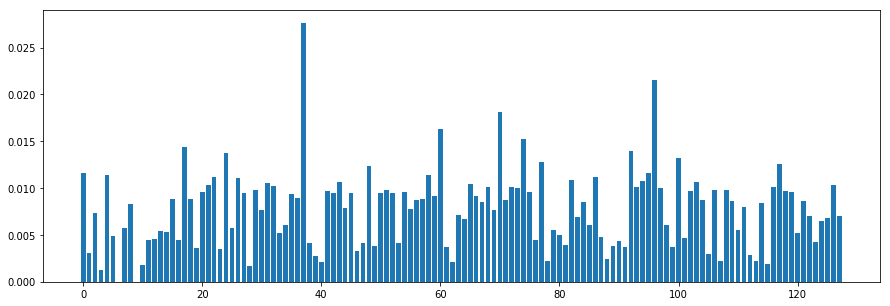

Train Epoch: 121 [0/2057 (0%)]	Loss: 3220.3716
====> Epoch: 121 Average train loss: 0.26561
====> Epoch: 121 Average test loss: 0.22493
Train Epoch: 122 [0/2057 (0%)]	Loss: 3408.1750
====> Epoch: 122 Average train loss: 0.27083
====> Epoch: 122 Average test loss: 0.22393
Train Epoch: 123 [0/2057 (0%)]	Loss: 3019.4504
====> Epoch: 123 Average train loss: 0.26643
====> Epoch: 123 Average test loss: 0.22447
Train Epoch: 124 [0/2057 (0%)]	Loss: 3352.1511
====> Epoch: 124 Average train loss: 0.26646
====> Epoch: 124 Average test loss: 0.22275
Train Epoch: 125 [0/2057 (0%)]	Loss: 3098.0195
====> Epoch: 125 Average train loss: 0.26679
====> Epoch: 125 Average test loss: 0.22504
Train Epoch: 126 [0/2057 (0%)]	Loss: 3268.0300
====> Epoch: 126 Average train loss: 0.26632
====> Epoch: 126 Average test loss: 0.22072
Train Epoch: 127 [0/2057 (0%)]	Loss: 3282.0671
====> Epoch: 127 Average train loss: 0.26459
====> Epoch: 127 Average test loss: 0.22042
Train Epoch: 128 [0/2057 (0%)]	Loss: 3583.9414
=

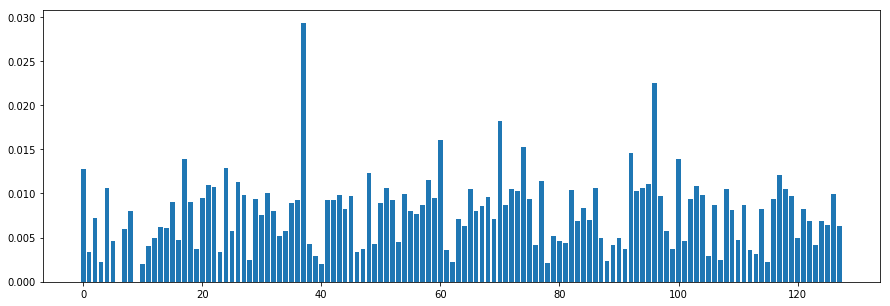

Train Epoch: 131 [0/2057 (0%)]	Loss: 3311.3384
====> Epoch: 131 Average train loss: 0.26737
====> Epoch: 131 Average test loss: 0.22556
Train Epoch: 132 [0/2057 (0%)]	Loss: 3121.9917
====> Epoch: 132 Average train loss: 0.26520
====> Epoch: 132 Average test loss: 0.22290
Train Epoch: 133 [0/2057 (0%)]	Loss: 3421.1765
====> Epoch: 133 Average train loss: 0.26771
====> Epoch: 133 Average test loss: 0.22093
Train Epoch: 134 [0/2057 (0%)]	Loss: 3441.2825
====> Epoch: 134 Average train loss: 0.26552
====> Epoch: 134 Average test loss: 0.22132
Train Epoch: 135 [0/2057 (0%)]	Loss: 3164.6589
====> Epoch: 135 Average train loss: 0.26589
====> Epoch: 135 Average test loss: 0.22082
Train Epoch: 136 [0/2057 (0%)]	Loss: 3112.2251
====> Epoch: 136 Average train loss: 0.26325
====> Epoch: 136 Average test loss: 0.22288
Train Epoch: 137 [0/2057 (0%)]	Loss: 3243.3604
====> Epoch: 137 Average train loss: 0.26650
====> Epoch: 137 Average test loss: 0.22425
Train Epoch: 138 [0/2057 (0%)]	Loss: 3139.7959
=

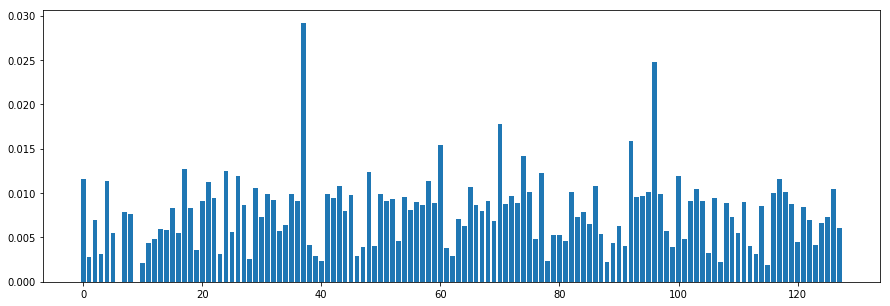

Train Epoch: 141 [0/2057 (0%)]	Loss: 3262.9458
====> Epoch: 141 Average train loss: 0.26481
====> Epoch: 141 Average test loss: 0.22182
Train Epoch: 142 [0/2057 (0%)]	Loss: 3460.2488
====> Epoch: 142 Average train loss: 0.26241
====> Epoch: 142 Average test loss: 0.22348
Train Epoch: 143 [0/2057 (0%)]	Loss: 3015.9294
====> Epoch: 143 Average train loss: 0.26526
====> Epoch: 143 Average test loss: 0.22085
Train Epoch: 144 [0/2057 (0%)]	Loss: 3301.3572
====> Epoch: 144 Average train loss: 0.26456
====> Epoch: 144 Average test loss: 0.22264
Train Epoch: 145 [0/2057 (0%)]	Loss: 3198.4043
====> Epoch: 145 Average train loss: 0.26593
====> Epoch: 145 Average test loss: 0.22296
Train Epoch: 146 [0/2057 (0%)]	Loss: 3271.1189
====> Epoch: 146 Average train loss: 0.26590
====> Epoch: 146 Average test loss: 0.22265
Train Epoch: 147 [0/2057 (0%)]	Loss: 3148.7004
====> Epoch: 147 Average train loss: 0.26647
====> Epoch: 147 Average test loss: 0.22403
Train Epoch: 148 [0/2057 (0%)]	Loss: 3345.2063
=

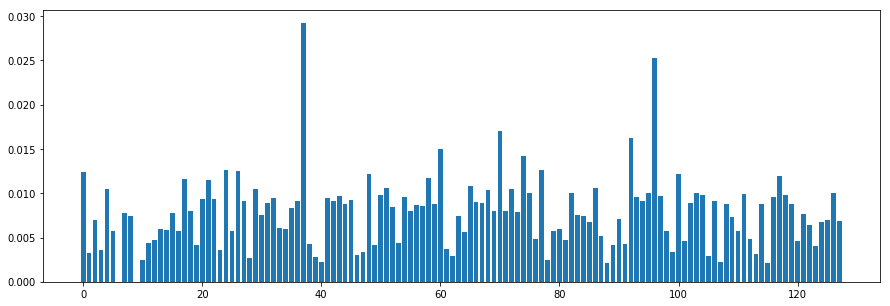

Train Epoch: 151 [0/2057 (0%)]	Loss: 3135.5640
====> Epoch: 151 Average train loss: 0.26580
====> Epoch: 151 Average test loss: 0.22472
Train Epoch: 152 [0/2057 (0%)]	Loss: 3059.5144
====> Epoch: 152 Average train loss: 0.26051
====> Epoch: 152 Average test loss: 0.22150
Train Epoch: 153 [0/2057 (0%)]	Loss: 3421.8311
====> Epoch: 153 Average train loss: 0.26442
====> Epoch: 153 Average test loss: 0.21888
Train Epoch: 154 [0/2057 (0%)]	Loss: 3053.0889
====> Epoch: 154 Average train loss: 0.26306
====> Epoch: 154 Average test loss: 0.22619
Train Epoch: 155 [0/2057 (0%)]	Loss: 3093.8452
====> Epoch: 155 Average train loss: 0.26291
====> Epoch: 155 Average test loss: 0.22193
Train Epoch: 156 [0/2057 (0%)]	Loss: 3389.7275
====> Epoch: 156 Average train loss: 0.26221
====> Epoch: 156 Average test loss: 0.21945
Train Epoch: 157 [0/2057 (0%)]	Loss: 3087.4475
====> Epoch: 157 Average train loss: 0.26361
====> Epoch: 157 Average test loss: 0.22540
Train Epoch: 158 [0/2057 (0%)]	Loss: 3296.2693
=

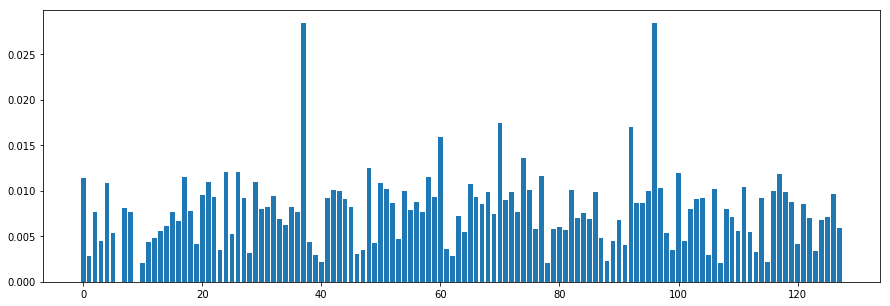

Train Epoch: 161 [0/2057 (0%)]	Loss: 2898.2087
====> Epoch: 161 Average train loss: 0.26448
====> Epoch: 161 Average test loss: 0.21972
Train Epoch: 162 [0/2057 (0%)]	Loss: 3079.0957
====> Epoch: 162 Average train loss: 0.26226
====> Epoch: 162 Average test loss: 0.22094
Train Epoch: 163 [0/2057 (0%)]	Loss: 2837.2212
====> Epoch: 163 Average train loss: 0.26127
====> Epoch: 163 Average test loss: 0.22014
Train Epoch: 164 [0/2057 (0%)]	Loss: 3319.1152
====> Epoch: 164 Average train loss: 0.26107
====> Epoch: 164 Average test loss: 0.22461
Train Epoch: 165 [0/2057 (0%)]	Loss: 3043.5642
====> Epoch: 165 Average train loss: 0.26490
====> Epoch: 165 Average test loss: 0.22021
Train Epoch: 166 [0/2057 (0%)]	Loss: 2624.1267
====> Epoch: 166 Average train loss: 0.26233
====> Epoch: 166 Average test loss: 0.22376
Train Epoch: 167 [0/2057 (0%)]	Loss: 3003.7190
====> Epoch: 167 Average train loss: 0.26265
====> Epoch: 167 Average test loss: 0.22082
Train Epoch: 168 [0/2057 (0%)]	Loss: 3236.5696
=

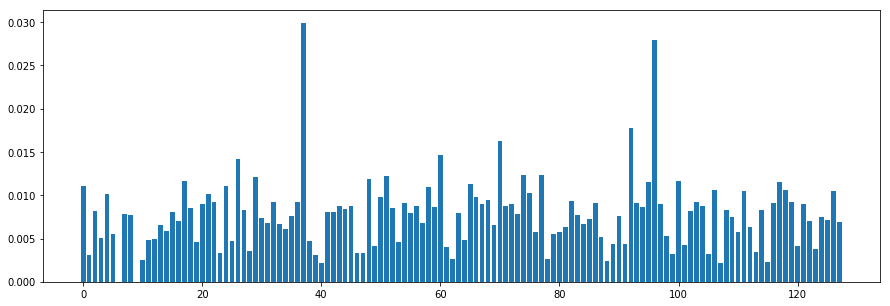

Train Epoch: 171 [0/2057 (0%)]	Loss: 3157.0127
====> Epoch: 171 Average train loss: 0.26190
====> Epoch: 171 Average test loss: 0.22110
Train Epoch: 172 [0/2057 (0%)]	Loss: 3745.0581
====> Epoch: 172 Average train loss: 0.26130
====> Epoch: 172 Average test loss: 0.22167
Train Epoch: 173 [0/2057 (0%)]	Loss: 3451.7688
====> Epoch: 173 Average train loss: 0.26210
====> Epoch: 173 Average test loss: 0.22242
Train Epoch: 174 [0/2057 (0%)]	Loss: 2881.8650
====> Epoch: 174 Average train loss: 0.26216
====> Epoch: 174 Average test loss: 0.22030
Train Epoch: 175 [0/2057 (0%)]	Loss: 2821.2773
====> Epoch: 175 Average train loss: 0.26383
====> Epoch: 175 Average test loss: 0.21936
Train Epoch: 176 [0/2057 (0%)]	Loss: 2894.1921
====> Epoch: 176 Average train loss: 0.25996
====> Epoch: 176 Average test loss: 0.21834
Train Epoch: 177 [0/2057 (0%)]	Loss: 3447.3584
====> Epoch: 177 Average train loss: 0.26244
====> Epoch: 177 Average test loss: 0.22194
Train Epoch: 178 [0/2057 (0%)]	Loss: 3474.6467
=

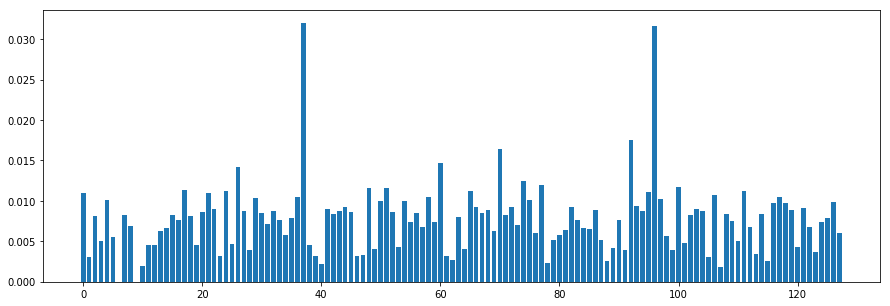

Train Epoch: 181 [0/2057 (0%)]	Loss: 2991.1497
====> Epoch: 181 Average train loss: 0.26123
====> Epoch: 181 Average test loss: 0.22268
Train Epoch: 182 [0/2057 (0%)]	Loss: 2819.0286
====> Epoch: 182 Average train loss: 0.26161
====> Epoch: 182 Average test loss: 0.21937
Train Epoch: 183 [0/2057 (0%)]	Loss: 2937.5989
====> Epoch: 183 Average train loss: 0.26172
====> Epoch: 183 Average test loss: 0.22290
Train Epoch: 184 [0/2057 (0%)]	Loss: 3294.9983
====> Epoch: 184 Average train loss: 0.26202
====> Epoch: 184 Average test loss: 0.22071
Train Epoch: 185 [0/2057 (0%)]	Loss: 3371.9932
====> Epoch: 185 Average train loss: 0.26052
====> Epoch: 185 Average test loss: 0.22117
Train Epoch: 186 [0/2057 (0%)]	Loss: 3398.1760
====> Epoch: 186 Average train loss: 0.26028
====> Epoch: 186 Average test loss: 0.22088
Train Epoch: 187 [0/2057 (0%)]	Loss: 3353.4038
====> Epoch: 187 Average train loss: 0.26134
====> Epoch: 187 Average test loss: 0.22016
Train Epoch: 188 [0/2057 (0%)]	Loss: 3485.0132
=

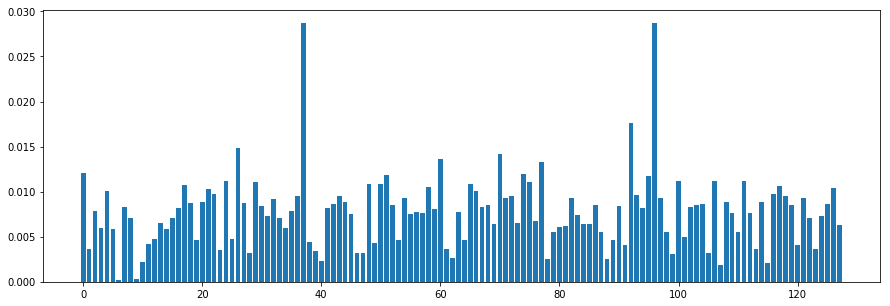

Train Epoch: 191 [0/2057 (0%)]	Loss: 3287.3645
====> Epoch: 191 Average train loss: 0.25933
====> Epoch: 191 Average test loss: 0.22061
Train Epoch: 192 [0/2057 (0%)]	Loss: 3340.1172
====> Epoch: 192 Average train loss: 0.26143
====> Epoch: 192 Average test loss: 0.21965
Train Epoch: 193 [0/2057 (0%)]	Loss: 3598.8848
====> Epoch: 193 Average train loss: 0.26112
====> Epoch: 193 Average test loss: 0.21920
Train Epoch: 194 [0/2057 (0%)]	Loss: 3162.8479
====> Epoch: 194 Average train loss: 0.26145
====> Epoch: 194 Average test loss: 0.22341
Train Epoch: 195 [0/2057 (0%)]	Loss: 3386.4116
====> Epoch: 195 Average train loss: 0.25945
====> Epoch: 195 Average test loss: 0.21955
Train Epoch: 196 [0/2057 (0%)]	Loss: 2918.3784
====> Epoch: 196 Average train loss: 0.25939
====> Epoch: 196 Average test loss: 0.21782
Train Epoch: 197 [0/2057 (0%)]	Loss: 3423.6309
====> Epoch: 197 Average train loss: 0.26313
====> Epoch: 197 Average test loss: 0.21877
Train Epoch: 198 [0/2057 (0%)]	Loss: 3707.3479
=

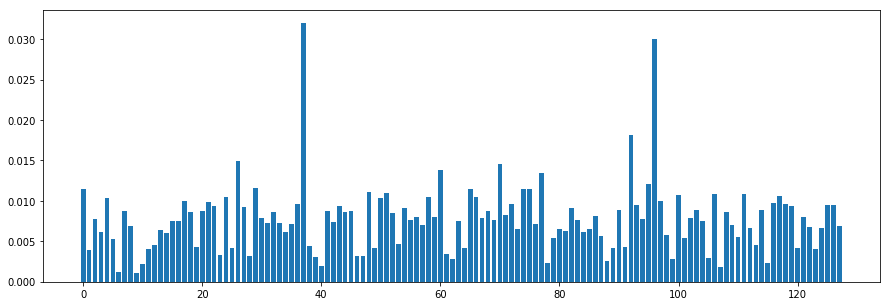

Train Epoch: 201 [0/2057 (0%)]	Loss: 3558.3467
====> Epoch: 201 Average train loss: 0.25882
====> Epoch: 201 Average test loss: 0.22020
Train Epoch: 202 [0/2057 (0%)]	Loss: 2885.9360
====> Epoch: 202 Average train loss: 0.25885
====> Epoch: 202 Average test loss: 0.22176
Train Epoch: 203 [0/2057 (0%)]	Loss: 3224.7488
====> Epoch: 203 Average train loss: 0.26163
====> Epoch: 203 Average test loss: 0.21884
Train Epoch: 204 [0/2057 (0%)]	Loss: 3368.0486
====> Epoch: 204 Average train loss: 0.25884
====> Epoch: 204 Average test loss: 0.22477
Train Epoch: 205 [0/2057 (0%)]	Loss: 3291.6343
====> Epoch: 205 Average train loss: 0.25801
====> Epoch: 205 Average test loss: 0.22221
Train Epoch: 206 [0/2057 (0%)]	Loss: 3222.8823
====> Epoch: 206 Average train loss: 0.25880
====> Epoch: 206 Average test loss: 0.22137
Train Epoch: 207 [0/2057 (0%)]	Loss: 2942.2358
====> Epoch: 207 Average train loss: 0.25918
====> Epoch: 207 Average test loss: 0.21839
Train Epoch: 208 [0/2057 (0%)]	Loss: 3302.4099
=

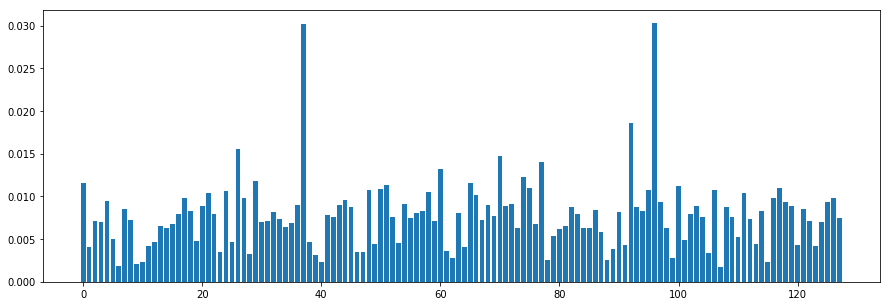

Train Epoch: 211 [0/2057 (0%)]	Loss: 3156.0520
====> Epoch: 211 Average train loss: 0.25917
====> Epoch: 211 Average test loss: 0.21996
Train Epoch: 212 [0/2057 (0%)]	Loss: 2811.9329
====> Epoch: 212 Average train loss: 0.25856
====> Epoch: 212 Average test loss: 0.21937
Train Epoch: 213 [0/2057 (0%)]	Loss: 3167.7979
====> Epoch: 213 Average train loss: 0.25997
====> Epoch: 213 Average test loss: 0.22069
Train Epoch: 214 [0/2057 (0%)]	Loss: 2962.8967
====> Epoch: 214 Average train loss: 0.25692
====> Epoch: 214 Average test loss: 0.22411
Train Epoch: 215 [0/2057 (0%)]	Loss: 2809.8081
====> Epoch: 215 Average train loss: 0.26021
====> Epoch: 215 Average test loss: 0.21769
Train Epoch: 216 [0/2057 (0%)]	Loss: 2979.1558
====> Epoch: 216 Average train loss: 0.25746
====> Epoch: 216 Average test loss: 0.21966
Train Epoch: 217 [0/2057 (0%)]	Loss: 3231.3804
====> Epoch: 217 Average train loss: 0.25855
====> Epoch: 217 Average test loss: 0.21846
Train Epoch: 218 [0/2057 (0%)]	Loss: 3633.9531
=

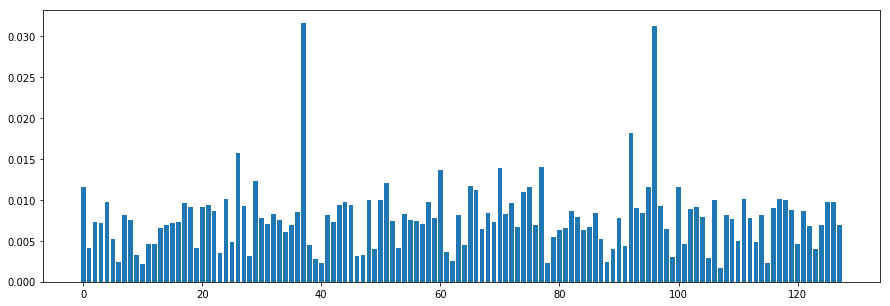

Train Epoch: 221 [0/2057 (0%)]	Loss: 3201.0952
====> Epoch: 221 Average train loss: 0.25759
====> Epoch: 221 Average test loss: 0.22019
Train Epoch: 222 [0/2057 (0%)]	Loss: 2661.8499
====> Epoch: 222 Average train loss: 0.26011
====> Epoch: 222 Average test loss: 0.21849
Train Epoch: 223 [0/2057 (0%)]	Loss: 3118.4585
====> Epoch: 223 Average train loss: 0.25735
====> Epoch: 223 Average test loss: 0.21807
Train Epoch: 224 [0/2057 (0%)]	Loss: 2918.6631
====> Epoch: 224 Average train loss: 0.25993
====> Epoch: 224 Average test loss: 0.21960
Train Epoch: 225 [0/2057 (0%)]	Loss: 3544.2390
====> Epoch: 225 Average train loss: 0.26040
====> Epoch: 225 Average test loss: 0.22002
Train Epoch: 226 [0/2057 (0%)]	Loss: 2909.0137
====> Epoch: 226 Average train loss: 0.25754
====> Epoch: 226 Average test loss: 0.22112
Train Epoch: 227 [0/2057 (0%)]	Loss: 2785.7861
====> Epoch: 227 Average train loss: 0.25690
====> Epoch: 227 Average test loss: 0.22098
Train Epoch: 228 [0/2057 (0%)]	Loss: 3239.3918
=

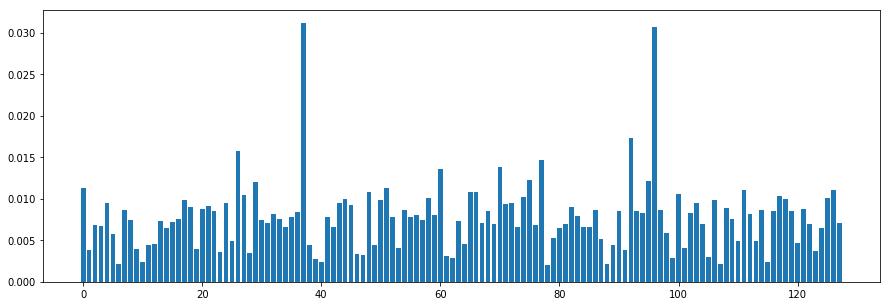

Train Epoch: 231 [0/2057 (0%)]	Loss: 3024.1785
====> Epoch: 231 Average train loss: 0.25822
====> Epoch: 231 Average test loss: 0.21878
Train Epoch: 232 [0/2057 (0%)]	Loss: 3300.3848
====> Epoch: 232 Average train loss: 0.25813
====> Epoch: 232 Average test loss: 0.22023
Train Epoch: 233 [0/2057 (0%)]	Loss: 2944.2498
====> Epoch: 233 Average train loss: 0.25856
====> Epoch: 233 Average test loss: 0.21992
Train Epoch: 234 [0/2057 (0%)]	Loss: 3215.1104
====> Epoch: 234 Average train loss: 0.25963
====> Epoch: 234 Average test loss: 0.21659
Train Epoch: 235 [0/2057 (0%)]	Loss: 3198.6658
====> Epoch: 235 Average train loss: 0.25789
====> Epoch: 235 Average test loss: 0.21715
Train Epoch: 236 [0/2057 (0%)]	Loss: 3180.6995
====> Epoch: 236 Average train loss: 0.25863
====> Epoch: 236 Average test loss: 0.21675
Train Epoch: 237 [0/2057 (0%)]	Loss: 3061.7554
====> Epoch: 237 Average train loss: 0.25972
====> Epoch: 237 Average test loss: 0.21738
Train Epoch: 238 [0/2057 (0%)]	Loss: 3029.9810
=

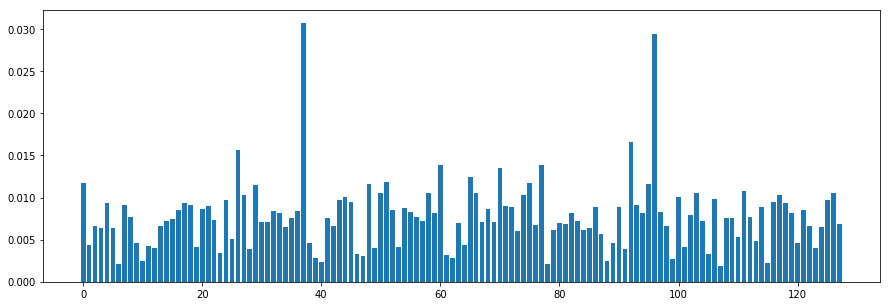

Train Epoch: 241 [0/2057 (0%)]	Loss: 3113.1660
====> Epoch: 241 Average train loss: 0.25701
====> Epoch: 241 Average test loss: 0.21896
Train Epoch: 242 [0/2057 (0%)]	Loss: 3186.2505
====> Epoch: 242 Average train loss: 0.25735
====> Epoch: 242 Average test loss: 0.21957
Train Epoch: 243 [0/2057 (0%)]	Loss: 2817.1296
====> Epoch: 243 Average train loss: 0.25687
====> Epoch: 243 Average test loss: 0.21951
Train Epoch: 244 [0/2057 (0%)]	Loss: 3361.7673
====> Epoch: 244 Average train loss: 0.25611
====> Epoch: 244 Average test loss: 0.21726
Train Epoch: 245 [0/2057 (0%)]	Loss: 2986.2368
====> Epoch: 245 Average train loss: 0.25675
====> Epoch: 245 Average test loss: 0.21862
Train Epoch: 246 [0/2057 (0%)]	Loss: 2900.9827
====> Epoch: 246 Average train loss: 0.25571
====> Epoch: 246 Average test loss: 0.21745
Train Epoch: 247 [0/2057 (0%)]	Loss: 3313.3130
====> Epoch: 247 Average train loss: 0.25650
====> Epoch: 247 Average test loss: 0.21742
Train Epoch: 248 [0/2057 (0%)]	Loss: 2909.5986
=

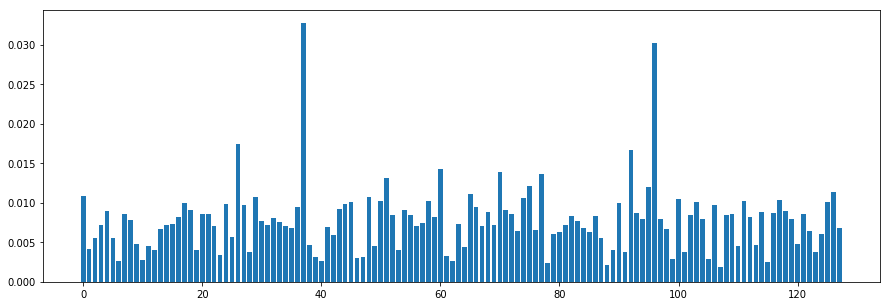

Train Epoch: 251 [0/2057 (0%)]	Loss: 3041.8152
====> Epoch: 251 Average train loss: 0.25629
====> Epoch: 251 Average test loss: 0.21839
Train Epoch: 252 [0/2057 (0%)]	Loss: 3063.9927
====> Epoch: 252 Average train loss: 0.25548
====> Epoch: 252 Average test loss: 0.22022
Train Epoch: 253 [0/2057 (0%)]	Loss: 2669.7283
====> Epoch: 253 Average train loss: 0.25660
====> Epoch: 253 Average test loss: 0.22485
Train Epoch: 254 [0/2057 (0%)]	Loss: 2993.9395
====> Epoch: 254 Average train loss: 0.25656
====> Epoch: 254 Average test loss: 0.21779
Train Epoch: 255 [0/2057 (0%)]	Loss: 2843.8877
====> Epoch: 255 Average train loss: 0.25417
====> Epoch: 255 Average test loss: 0.22074
Train Epoch: 256 [0/2057 (0%)]	Loss: 3159.4602
====> Epoch: 256 Average train loss: 0.25746
====> Epoch: 256 Average test loss: 0.21863
Train Epoch: 257 [0/2057 (0%)]	Loss: 3032.0371
====> Epoch: 257 Average train loss: 0.25616
====> Epoch: 257 Average test loss: 0.21737
Train Epoch: 258 [0/2057 (0%)]	Loss: 3333.7053
=

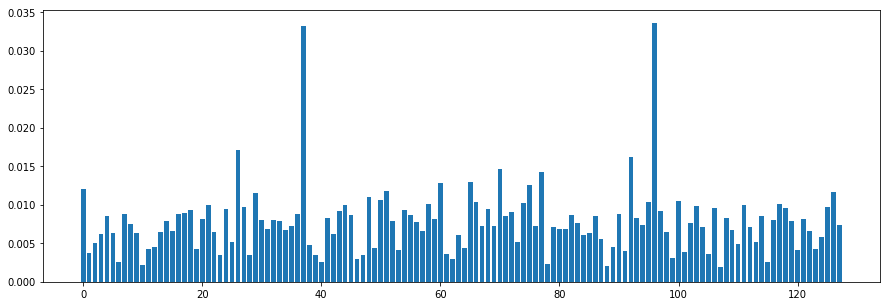

Train Epoch: 261 [0/2057 (0%)]	Loss: 3041.3528
====> Epoch: 261 Average train loss: 0.25503
====> Epoch: 261 Average test loss: 0.22081
Train Epoch: 262 [0/2057 (0%)]	Loss: 3218.4199
====> Epoch: 262 Average train loss: 0.25673
====> Epoch: 262 Average test loss: 0.21941
Train Epoch: 263 [0/2057 (0%)]	Loss: 2898.3743
====> Epoch: 263 Average train loss: 0.25729
====> Epoch: 263 Average test loss: 0.21816
Train Epoch: 264 [0/2057 (0%)]	Loss: 3453.6741
====> Epoch: 264 Average train loss: 0.25533
====> Epoch: 264 Average test loss: 0.22019
Train Epoch: 265 [0/2057 (0%)]	Loss: 3120.0098
====> Epoch: 265 Average train loss: 0.25376
====> Epoch: 265 Average test loss: 0.22014
Train Epoch: 266 [0/2057 (0%)]	Loss: 3222.0156
====> Epoch: 266 Average train loss: 0.25809
====> Epoch: 266 Average test loss: 0.22130
Train Epoch: 267 [0/2057 (0%)]	Loss: 3222.5996
====> Epoch: 267 Average train loss: 0.25666
====> Epoch: 267 Average test loss: 0.22062
Train Epoch: 268 [0/2057 (0%)]	Loss: 2922.6040
=

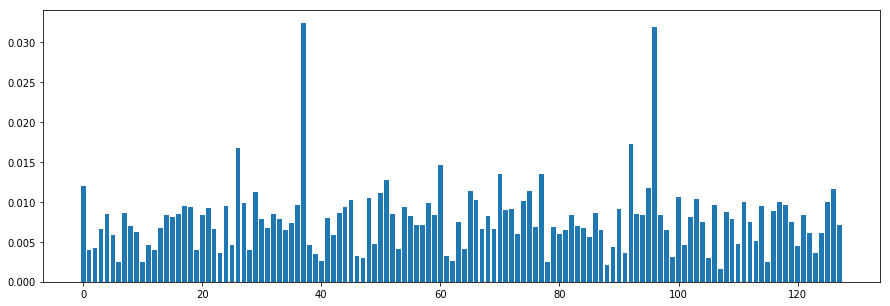

Train Epoch: 271 [0/2057 (0%)]	Loss: 3389.5837
====> Epoch: 271 Average train loss: 0.25723
====> Epoch: 271 Average test loss: 0.21853
Train Epoch: 272 [0/2057 (0%)]	Loss: 2859.1726
====> Epoch: 272 Average train loss: 0.25665
====> Epoch: 272 Average test loss: 0.21816
Train Epoch: 273 [0/2057 (0%)]	Loss: 3370.8457
====> Epoch: 273 Average train loss: 0.25649
====> Epoch: 273 Average test loss: 0.21892
Train Epoch: 274 [0/2057 (0%)]	Loss: 3155.2007
====> Epoch: 274 Average train loss: 0.25604
====> Epoch: 274 Average test loss: 0.21750
Train Epoch: 275 [0/2057 (0%)]	Loss: 3239.9648
====> Epoch: 275 Average train loss: 0.25533
====> Epoch: 275 Average test loss: 0.21795
Train Epoch: 276 [0/2057 (0%)]	Loss: 3309.2463
====> Epoch: 276 Average train loss: 0.25475
====> Epoch: 276 Average test loss: 0.22020
Train Epoch: 277 [0/2057 (0%)]	Loss: 3073.8252
====> Epoch: 277 Average train loss: 0.25507
====> Epoch: 277 Average test loss: 0.21753
Train Epoch: 278 [0/2057 (0%)]	Loss: 3046.3313
=

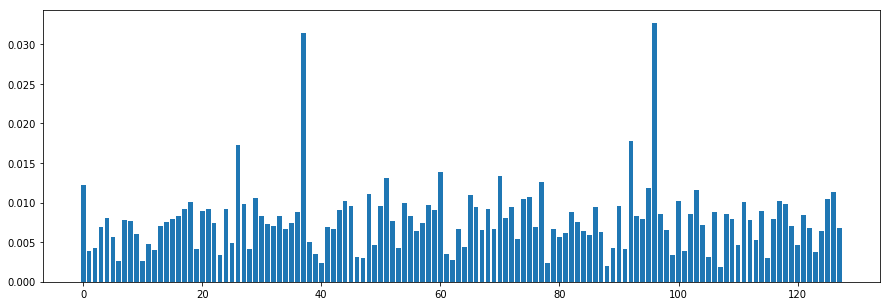

Train Epoch: 281 [0/2057 (0%)]	Loss: 3106.7375
====> Epoch: 281 Average train loss: 0.25350
====> Epoch: 281 Average test loss: 0.21559
Train Epoch: 282 [0/2057 (0%)]	Loss: 2756.5776
====> Epoch: 282 Average train loss: 0.25458
====> Epoch: 282 Average test loss: 0.21864
Train Epoch: 283 [0/2057 (0%)]	Loss: 3167.2173
====> Epoch: 283 Average train loss: 0.25465
====> Epoch: 283 Average test loss: 0.21777
Train Epoch: 284 [0/2057 (0%)]	Loss: 3617.5122
====> Epoch: 284 Average train loss: 0.25777
====> Epoch: 284 Average test loss: 0.21596
Train Epoch: 285 [0/2057 (0%)]	Loss: 2962.7014
====> Epoch: 285 Average train loss: 0.25366
====> Epoch: 285 Average test loss: 0.21652
Train Epoch: 286 [0/2057 (0%)]	Loss: 2907.0137
====> Epoch: 286 Average train loss: 0.25430
====> Epoch: 286 Average test loss: 0.21938
Train Epoch: 287 [0/2057 (0%)]	Loss: 3121.1023
====> Epoch: 287 Average train loss: 0.25530
====> Epoch: 287 Average test loss: 0.21780
Train Epoch: 288 [0/2057 (0%)]	Loss: 3002.9272
=

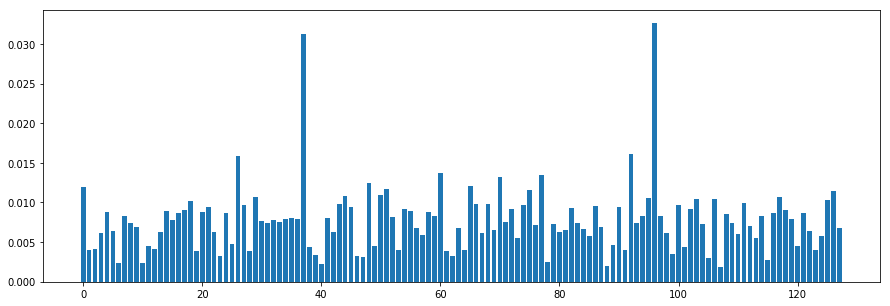

Train Epoch: 291 [0/2057 (0%)]	Loss: 2946.6104
====> Epoch: 291 Average train loss: 0.25648
====> Epoch: 291 Average test loss: 0.22239
Train Epoch: 292 [0/2057 (0%)]	Loss: 2897.5625
====> Epoch: 292 Average train loss: 0.25303
====> Epoch: 292 Average test loss: 0.22154
Train Epoch: 293 [0/2057 (0%)]	Loss: 3066.4080
====> Epoch: 293 Average train loss: 0.25250
====> Epoch: 293 Average test loss: 0.21783
Train Epoch: 294 [0/2057 (0%)]	Loss: 3132.2249
====> Epoch: 294 Average train loss: 0.25491
====> Epoch: 294 Average test loss: 0.22196
Train Epoch: 295 [0/2057 (0%)]	Loss: 3494.9336
====> Epoch: 295 Average train loss: 0.25818
====> Epoch: 295 Average test loss: 0.22036
Train Epoch: 296 [0/2057 (0%)]	Loss: 3012.5803
====> Epoch: 296 Average train loss: 0.25387
====> Epoch: 296 Average test loss: 0.22046
Train Epoch: 297 [0/2057 (0%)]	Loss: 2860.9285
====> Epoch: 297 Average train loss: 0.25420
====> Epoch: 297 Average test loss: 0.21631
Train Epoch: 298 [0/2057 (0%)]	Loss: 2954.6458
=

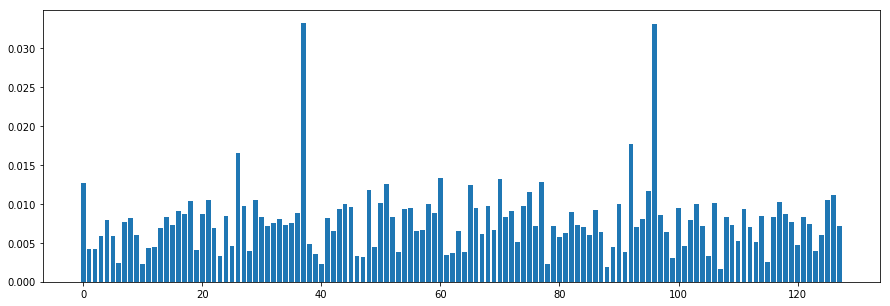

Train Epoch: 301 [0/2057 (0%)]	Loss: 3444.6865
====> Epoch: 301 Average train loss: 0.25721
====> Epoch: 301 Average test loss: 0.21668
Train Epoch: 302 [0/2057 (0%)]	Loss: 2976.2817
====> Epoch: 302 Average train loss: 0.25388
====> Epoch: 302 Average test loss: 0.21979
Train Epoch: 303 [0/2057 (0%)]	Loss: 3269.9817
====> Epoch: 303 Average train loss: 0.25389
====> Epoch: 303 Average test loss: 0.22042
Train Epoch: 304 [0/2057 (0%)]	Loss: 2882.4675
====> Epoch: 304 Average train loss: 0.25537
====> Epoch: 304 Average test loss: 0.22217
Train Epoch: 305 [0/2057 (0%)]	Loss: 3168.3767
====> Epoch: 305 Average train loss: 0.25420
====> Epoch: 305 Average test loss: 0.21655
Train Epoch: 306 [0/2057 (0%)]	Loss: 3445.7266
====> Epoch: 306 Average train loss: 0.25353
====> Epoch: 306 Average test loss: 0.21707
Train Epoch: 307 [0/2057 (0%)]	Loss: 3050.6492
====> Epoch: 307 Average train loss: 0.25279
====> Epoch: 307 Average test loss: 0.21711
Train Epoch: 308 [0/2057 (0%)]	Loss: 2953.0891
=

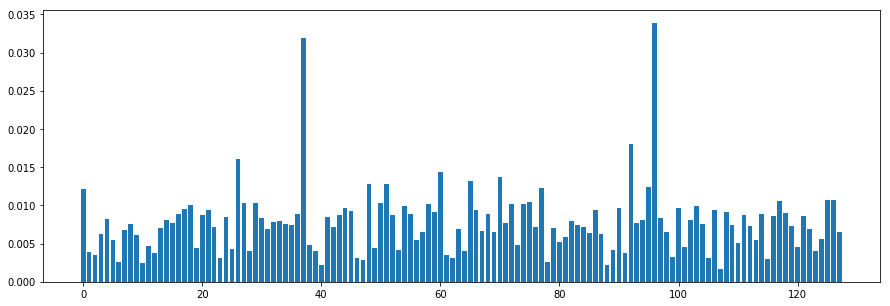

Train Epoch: 311 [0/2057 (0%)]	Loss: 2838.2910
====> Epoch: 311 Average train loss: 0.25261
====> Epoch: 311 Average test loss: 0.21989
Train Epoch: 312 [0/2057 (0%)]	Loss: 3100.2473
====> Epoch: 312 Average train loss: 0.25404
====> Epoch: 312 Average test loss: 0.21642
Train Epoch: 313 [0/2057 (0%)]	Loss: 2833.9187
====> Epoch: 313 Average train loss: 0.25431
====> Epoch: 313 Average test loss: 0.21734
Train Epoch: 314 [0/2057 (0%)]	Loss: 3096.5869
====> Epoch: 314 Average train loss: 0.25291
====> Epoch: 314 Average test loss: 0.21692
Train Epoch: 315 [0/2057 (0%)]	Loss: 2945.6646
====> Epoch: 315 Average train loss: 0.25290
====> Epoch: 315 Average test loss: 0.21845
Train Epoch: 316 [0/2057 (0%)]	Loss: 3180.4014
====> Epoch: 316 Average train loss: 0.25455
====> Epoch: 316 Average test loss: 0.21967
Train Epoch: 317 [0/2057 (0%)]	Loss: 3373.7000
====> Epoch: 317 Average train loss: 0.25432
====> Epoch: 317 Average test loss: 0.21888
Train Epoch: 318 [0/2057 (0%)]	Loss: 2968.3394
=

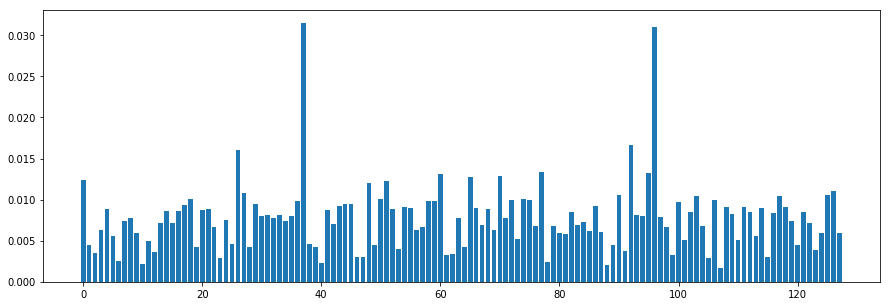

Train Epoch: 321 [0/2057 (0%)]	Loss: 2864.3833
====> Epoch: 321 Average train loss: 0.25538
====> Epoch: 321 Average test loss: 0.21584
Train Epoch: 322 [0/2057 (0%)]	Loss: 2924.3853
====> Epoch: 322 Average train loss: 0.25381
====> Epoch: 322 Average test loss: 0.21887
Train Epoch: 323 [0/2057 (0%)]	Loss: 2826.6135
====> Epoch: 323 Average train loss: 0.25303
====> Epoch: 323 Average test loss: 0.21654
Train Epoch: 324 [0/2057 (0%)]	Loss: 3484.8210
====> Epoch: 324 Average train loss: 0.25319
====> Epoch: 324 Average test loss: 0.21633
Train Epoch: 325 [0/2057 (0%)]	Loss: 2600.9175
====> Epoch: 325 Average train loss: 0.25404
====> Epoch: 325 Average test loss: 0.21817
Train Epoch: 326 [0/2057 (0%)]	Loss: 3181.3508
====> Epoch: 326 Average train loss: 0.25371
====> Epoch: 326 Average test loss: 0.21883
Train Epoch: 327 [0/2057 (0%)]	Loss: 2969.2393
====> Epoch: 327 Average train loss: 0.25173
====> Epoch: 327 Average test loss: 0.21859
Train Epoch: 328 [0/2057 (0%)]	Loss: 2766.1326
=

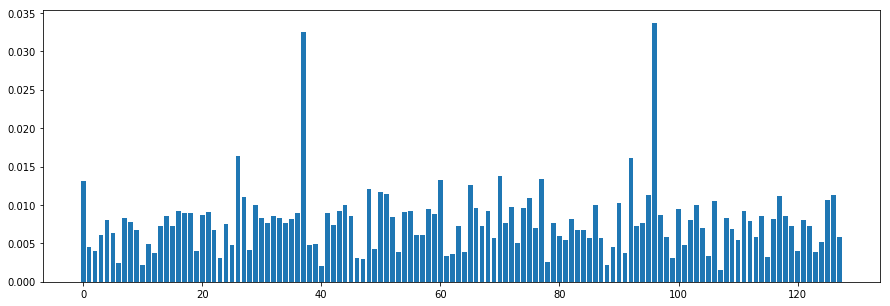

Train Epoch: 331 [0/2057 (0%)]	Loss: 2932.8364
====> Epoch: 331 Average train loss: 0.25395
====> Epoch: 331 Average test loss: 0.21944
Train Epoch: 332 [0/2057 (0%)]	Loss: 3015.5994
====> Epoch: 332 Average train loss: 0.25345
====> Epoch: 332 Average test loss: 0.21664
Train Epoch: 333 [0/2057 (0%)]	Loss: 2993.4031
====> Epoch: 333 Average train loss: 0.25294
====> Epoch: 333 Average test loss: 0.21739
Train Epoch: 334 [0/2057 (0%)]	Loss: 2974.8730
====> Epoch: 334 Average train loss: 0.25684
====> Epoch: 334 Average test loss: 0.21873
Train Epoch: 335 [0/2057 (0%)]	Loss: 2891.4194
====> Epoch: 335 Average train loss: 0.25472
====> Epoch: 335 Average test loss: 0.21576
Train Epoch: 336 [0/2057 (0%)]	Loss: 2802.2520
====> Epoch: 336 Average train loss: 0.25327
====> Epoch: 336 Average test loss: 0.21940
Train Epoch: 337 [0/2057 (0%)]	Loss: 3200.8892
====> Epoch: 337 Average train loss: 0.25674
====> Epoch: 337 Average test loss: 0.21764
Train Epoch: 338 [0/2057 (0%)]	Loss: 2931.3044
=

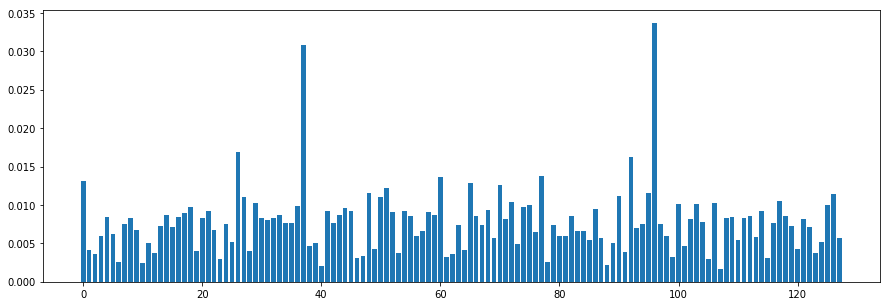

Train Epoch: 341 [0/2057 (0%)]	Loss: 3453.0122
====> Epoch: 341 Average train loss: 0.25232
====> Epoch: 341 Average test loss: 0.21772
Train Epoch: 342 [0/2057 (0%)]	Loss: 3143.4155
====> Epoch: 342 Average train loss: 0.25110
====> Epoch: 342 Average test loss: 0.21787
Train Epoch: 343 [0/2057 (0%)]	Loss: 3391.8372
====> Epoch: 343 Average train loss: 0.25199
====> Epoch: 343 Average test loss: 0.21909
Train Epoch: 344 [0/2057 (0%)]	Loss: 3081.8655
====> Epoch: 344 Average train loss: 0.25216
====> Epoch: 344 Average test loss: 0.22143
Train Epoch: 345 [0/2057 (0%)]	Loss: 2870.8105
====> Epoch: 345 Average train loss: 0.25213
====> Epoch: 345 Average test loss: 0.21985
Train Epoch: 346 [0/2057 (0%)]	Loss: 3184.0654
====> Epoch: 346 Average train loss: 0.25451
====> Epoch: 346 Average test loss: 0.21859
Train Epoch: 347 [0/2057 (0%)]	Loss: 2999.3738
====> Epoch: 347 Average train loss: 0.25504
====> Epoch: 347 Average test loss: 0.21874
Train Epoch: 348 [0/2057 (0%)]	Loss: 3109.1172
=

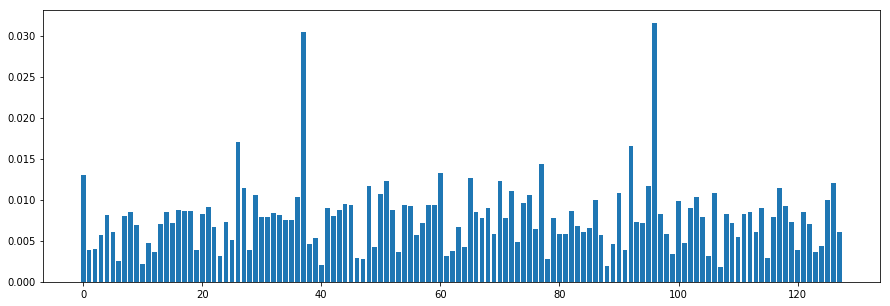

Train Epoch: 351 [0/2057 (0%)]	Loss: 3182.5000
====> Epoch: 351 Average train loss: 0.25386
====> Epoch: 351 Average test loss: 0.21747
Train Epoch: 352 [0/2057 (0%)]	Loss: 2973.3127
====> Epoch: 352 Average train loss: 0.25198
====> Epoch: 352 Average test loss: 0.21967
Train Epoch: 353 [0/2057 (0%)]	Loss: 3359.7712
====> Epoch: 353 Average train loss: 0.25233
====> Epoch: 353 Average test loss: 0.21864
Train Epoch: 354 [0/2057 (0%)]	Loss: 3281.0271
====> Epoch: 354 Average train loss: 0.25120
====> Epoch: 354 Average test loss: 0.21673
Train Epoch: 355 [0/2057 (0%)]	Loss: 2726.1528
====> Epoch: 355 Average train loss: 0.25154
====> Epoch: 355 Average test loss: 0.21772
Train Epoch: 356 [0/2057 (0%)]	Loss: 3158.1653
====> Epoch: 356 Average train loss: 0.25446
====> Epoch: 356 Average test loss: 0.21976
Train Epoch: 357 [0/2057 (0%)]	Loss: 2984.0471
====> Epoch: 357 Average train loss: 0.25146
====> Epoch: 357 Average test loss: 0.21926
Train Epoch: 358 [0/2057 (0%)]	Loss: 3032.3533
=

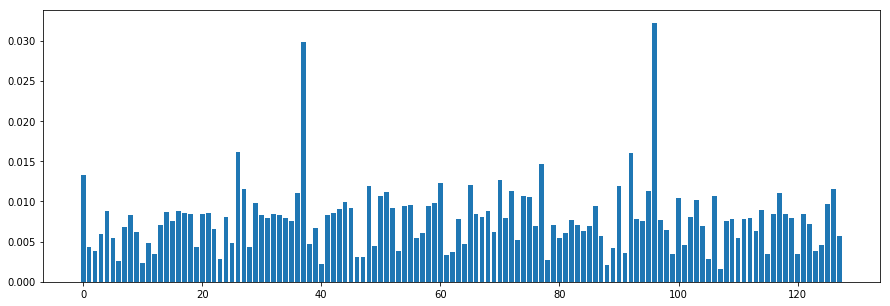

Train Epoch: 361 [0/2057 (0%)]	Loss: 2872.2349
====> Epoch: 361 Average train loss: 0.25418
====> Epoch: 361 Average test loss: 0.21782
Train Epoch: 362 [0/2057 (0%)]	Loss: 3124.6450
====> Epoch: 362 Average train loss: 0.25105
====> Epoch: 362 Average test loss: 0.21532
Train Epoch: 363 [0/2057 (0%)]	Loss: 2793.5156
====> Epoch: 363 Average train loss: 0.25191
====> Epoch: 363 Average test loss: 0.21678
Train Epoch: 364 [0/2057 (0%)]	Loss: 3253.1101
====> Epoch: 364 Average train loss: 0.25305
====> Epoch: 364 Average test loss: 0.21985
Train Epoch: 365 [0/2057 (0%)]	Loss: 3376.0737
====> Epoch: 365 Average train loss: 0.25206
====> Epoch: 365 Average test loss: 0.21484
Train Epoch: 366 [0/2057 (0%)]	Loss: 3464.0151
====> Epoch: 366 Average train loss: 0.25072
====> Epoch: 366 Average test loss: 0.21662
Train Epoch: 367 [0/2057 (0%)]	Loss: 3283.8254
====> Epoch: 367 Average train loss: 0.25209
====> Epoch: 367 Average test loss: 0.21955
Train Epoch: 368 [0/2057 (0%)]	Loss: 3313.4688
=

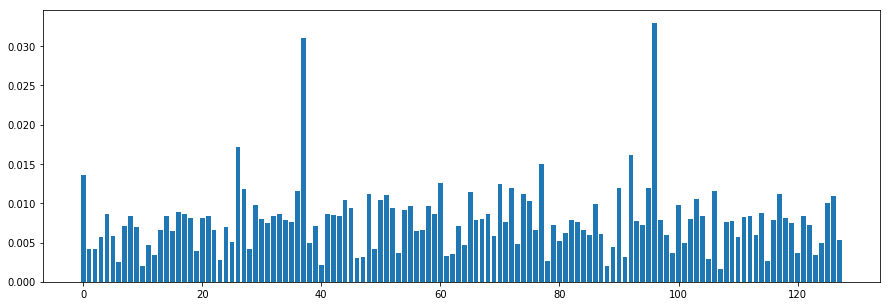

Train Epoch: 371 [0/2057 (0%)]	Loss: 3142.4019
====> Epoch: 371 Average train loss: 0.25182
====> Epoch: 371 Average test loss: 0.21999
Train Epoch: 372 [0/2057 (0%)]	Loss: 3050.4407
====> Epoch: 372 Average train loss: 0.25167
====> Epoch: 372 Average test loss: 0.21739
Train Epoch: 373 [0/2057 (0%)]	Loss: 3208.2197
====> Epoch: 373 Average train loss: 0.25269
====> Epoch: 373 Average test loss: 0.21846
Train Epoch: 374 [0/2057 (0%)]	Loss: 2829.4839
====> Epoch: 374 Average train loss: 0.25045
====> Epoch: 374 Average test loss: 0.21680
Train Epoch: 375 [0/2057 (0%)]	Loss: 3588.2537
====> Epoch: 375 Average train loss: 0.25212
====> Epoch: 375 Average test loss: 0.21978
Train Epoch: 376 [0/2057 (0%)]	Loss: 3370.7449
====> Epoch: 376 Average train loss: 0.25037
====> Epoch: 376 Average test loss: 0.21999
Train Epoch: 377 [0/2057 (0%)]	Loss: 3339.7563
====> Epoch: 377 Average train loss: 0.25074
====> Epoch: 377 Average test loss: 0.21797
Train Epoch: 378 [0/2057 (0%)]	Loss: 3296.4255
=

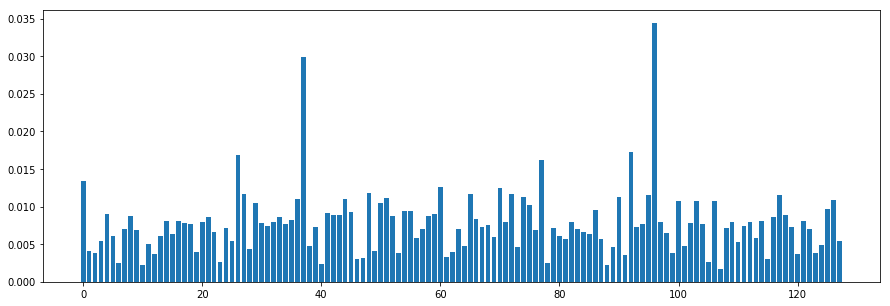

Train Epoch: 381 [0/2057 (0%)]	Loss: 2879.4314
====> Epoch: 381 Average train loss: 0.25047
====> Epoch: 381 Average test loss: 0.21732
Train Epoch: 382 [0/2057 (0%)]	Loss: 3029.2319
====> Epoch: 382 Average train loss: 0.25300
====> Epoch: 382 Average test loss: 0.21640
Train Epoch: 383 [0/2057 (0%)]	Loss: 2898.3640
====> Epoch: 383 Average train loss: 0.25084
====> Epoch: 383 Average test loss: 0.21962
Train Epoch: 384 [0/2057 (0%)]	Loss: 3186.7212
====> Epoch: 384 Average train loss: 0.25056
====> Epoch: 384 Average test loss: 0.21865
Train Epoch: 385 [0/2057 (0%)]	Loss: 3347.3621
====> Epoch: 385 Average train loss: 0.25091
====> Epoch: 385 Average test loss: 0.21958
Train Epoch: 386 [0/2057 (0%)]	Loss: 2596.4753
====> Epoch: 386 Average train loss: 0.24937
====> Epoch: 386 Average test loss: 0.21639
Train Epoch: 387 [0/2057 (0%)]	Loss: 3186.7656
====> Epoch: 387 Average train loss: 0.25287
====> Epoch: 387 Average test loss: 0.21934
Train Epoch: 388 [0/2057 (0%)]	Loss: 2992.6536
=

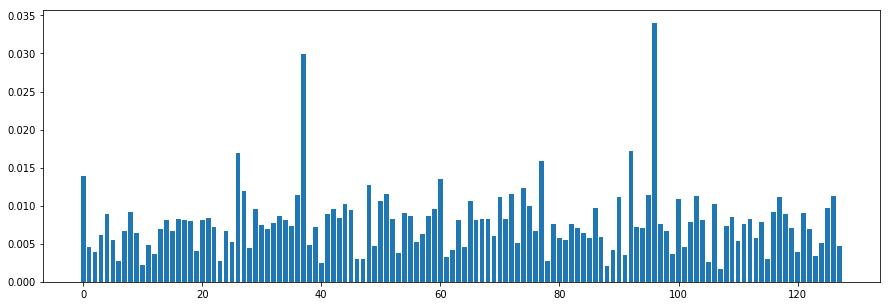

Train Epoch: 391 [0/2057 (0%)]	Loss: 3177.6082
====> Epoch: 391 Average train loss: 0.25317
====> Epoch: 391 Average test loss: 0.21708
Train Epoch: 392 [0/2057 (0%)]	Loss: 3387.3203
====> Epoch: 392 Average train loss: 0.24942
====> Epoch: 392 Average test loss: 0.21608
Train Epoch: 393 [0/2057 (0%)]	Loss: 3057.6741
====> Epoch: 393 Average train loss: 0.25321
====> Epoch: 393 Average test loss: 0.21567
Train Epoch: 394 [0/2057 (0%)]	Loss: 3356.8789
====> Epoch: 394 Average train loss: 0.25327
====> Epoch: 394 Average test loss: 0.21760
Train Epoch: 395 [0/2057 (0%)]	Loss: 2884.3364
====> Epoch: 395 Average train loss: 0.25227
====> Epoch: 395 Average test loss: 0.21940
Train Epoch: 396 [0/2057 (0%)]	Loss: 3186.7991
====> Epoch: 396 Average train loss: 0.25295
====> Epoch: 396 Average test loss: 0.21758
Train Epoch: 397 [0/2057 (0%)]	Loss: 3233.1638
====> Epoch: 397 Average train loss: 0.25191
====> Epoch: 397 Average test loss: 0.21830
Train Epoch: 398 [0/2057 (0%)]	Loss: 3070.5278
=

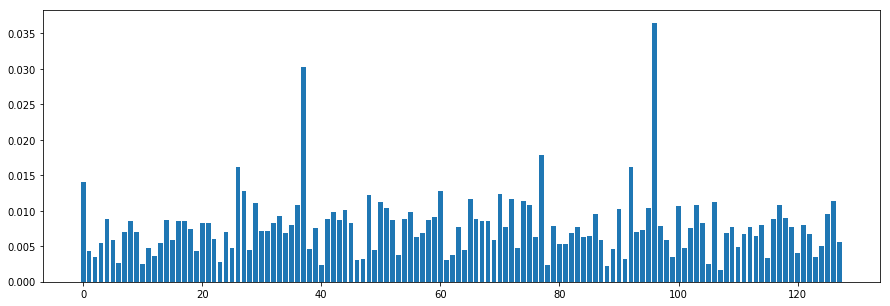

Train Epoch: 401 [0/2057 (0%)]	Loss: 3255.8027
====> Epoch: 401 Average train loss: 0.25060
====> Epoch: 401 Average test loss: 0.21944
Train Epoch: 402 [0/2057 (0%)]	Loss: 3323.0518
====> Epoch: 402 Average train loss: 0.25343
====> Epoch: 402 Average test loss: 0.21675
Train Epoch: 403 [0/2057 (0%)]	Loss: 3135.7776
====> Epoch: 403 Average train loss: 0.24922
====> Epoch: 403 Average test loss: 0.21593
Train Epoch: 404 [0/2057 (0%)]	Loss: 3483.5786
====> Epoch: 404 Average train loss: 0.25050
====> Epoch: 404 Average test loss: 0.21985
Train Epoch: 405 [0/2057 (0%)]	Loss: 3181.6702
====> Epoch: 405 Average train loss: 0.25009
====> Epoch: 405 Average test loss: 0.21720
Train Epoch: 406 [0/2057 (0%)]	Loss: 3055.3684
====> Epoch: 406 Average train loss: 0.25122
====> Epoch: 406 Average test loss: 0.21657
Train Epoch: 407 [0/2057 (0%)]	Loss: 2957.1890
====> Epoch: 407 Average train loss: 0.25119
====> Epoch: 407 Average test loss: 0.21922
Train Epoch: 408 [0/2057 (0%)]	Loss: 3042.9751
=

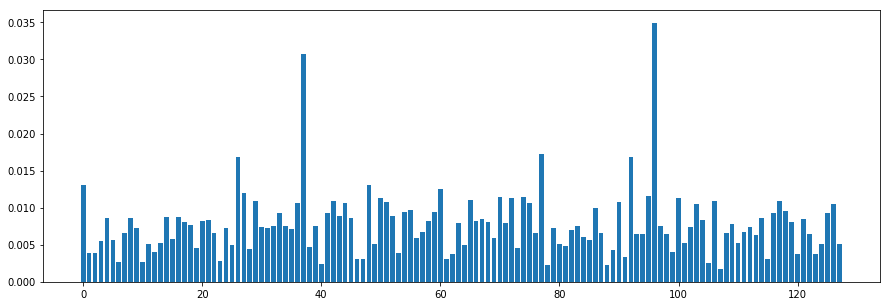

Train Epoch: 411 [0/2057 (0%)]	Loss: 3332.1899
====> Epoch: 411 Average train loss: 0.25247
====> Epoch: 411 Average test loss: 0.22285
Train Epoch: 412 [0/2057 (0%)]	Loss: 3343.3188
====> Epoch: 412 Average train loss: 0.25147
====> Epoch: 412 Average test loss: 0.22025
Train Epoch: 413 [0/2057 (0%)]	Loss: 2724.8550
====> Epoch: 413 Average train loss: 0.25039
====> Epoch: 413 Average test loss: 0.21704
Train Epoch: 414 [0/2057 (0%)]	Loss: 3388.0088
====> Epoch: 414 Average train loss: 0.25123
====> Epoch: 414 Average test loss: 0.21856
Train Epoch: 415 [0/2057 (0%)]	Loss: 3193.9197
====> Epoch: 415 Average train loss: 0.25076
====> Epoch: 415 Average test loss: 0.21733
Train Epoch: 416 [0/2057 (0%)]	Loss: 3022.0093
====> Epoch: 416 Average train loss: 0.25069
====> Epoch: 416 Average test loss: 0.21786
Train Epoch: 417 [0/2057 (0%)]	Loss: 2844.8916
====> Epoch: 417 Average train loss: 0.25254
====> Epoch: 417 Average test loss: 0.21737
Train Epoch: 418 [0/2057 (0%)]	Loss: 2783.7336
=

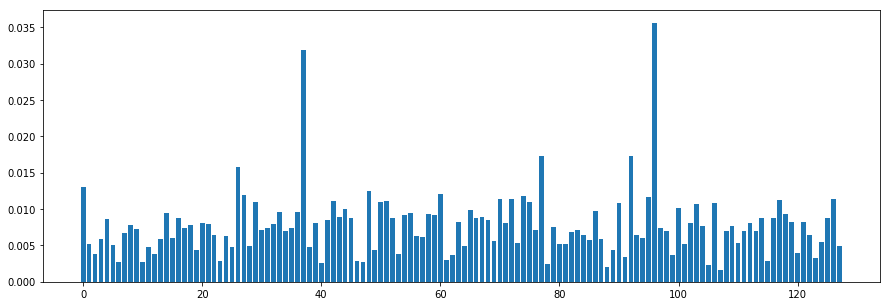

Train Epoch: 421 [0/2057 (0%)]	Loss: 2725.2361
====> Epoch: 421 Average train loss: 0.25177
====> Epoch: 421 Average test loss: 0.21685
Train Epoch: 422 [0/2057 (0%)]	Loss: 3566.7522
====> Epoch: 422 Average train loss: 0.24968
====> Epoch: 422 Average test loss: 0.21864
Train Epoch: 423 [0/2057 (0%)]	Loss: 3192.5278
====> Epoch: 423 Average train loss: 0.24969
====> Epoch: 423 Average test loss: 0.21830
Train Epoch: 424 [0/2057 (0%)]	Loss: 3062.8401
====> Epoch: 424 Average train loss: 0.25187
====> Epoch: 424 Average test loss: 0.21986
Train Epoch: 425 [0/2057 (0%)]	Loss: 3381.1511
====> Epoch: 425 Average train loss: 0.25117
====> Epoch: 425 Average test loss: 0.21912
Train Epoch: 426 [0/2057 (0%)]	Loss: 2876.9709
====> Epoch: 426 Average train loss: 0.25082
====> Epoch: 426 Average test loss: 0.21928
Train Epoch: 427 [0/2057 (0%)]	Loss: 3024.7068
====> Epoch: 427 Average train loss: 0.25159
====> Epoch: 427 Average test loss: 0.21671
Train Epoch: 428 [0/2057 (0%)]	Loss: 2872.1526
=

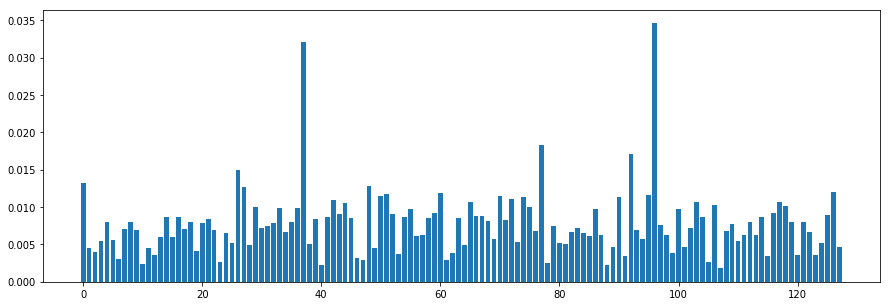

Train Epoch: 431 [0/2057 (0%)]	Loss: 3043.3977
====> Epoch: 431 Average train loss: 0.25027
====> Epoch: 431 Average test loss: 0.21777
Train Epoch: 432 [0/2057 (0%)]	Loss: 2855.1577
====> Epoch: 432 Average train loss: 0.25012
====> Epoch: 432 Average test loss: 0.21627
Train Epoch: 433 [0/2057 (0%)]	Loss: 2939.9368
====> Epoch: 433 Average train loss: 0.25136
====> Epoch: 433 Average test loss: 0.21939
Train Epoch: 434 [0/2057 (0%)]	Loss: 3074.3804
====> Epoch: 434 Average train loss: 0.24914
====> Epoch: 434 Average test loss: 0.21881
Train Epoch: 435 [0/2057 (0%)]	Loss: 2684.6272
====> Epoch: 435 Average train loss: 0.24969
====> Epoch: 435 Average test loss: 0.21879
Train Epoch: 436 [0/2057 (0%)]	Loss: 3548.6711
====> Epoch: 436 Average train loss: 0.25286
====> Epoch: 436 Average test loss: 0.21437
Train Epoch: 437 [0/2057 (0%)]	Loss: 3322.8723
====> Epoch: 437 Average train loss: 0.24887
====> Epoch: 437 Average test loss: 0.21746
Train Epoch: 438 [0/2057 (0%)]	Loss: 3105.8555
=

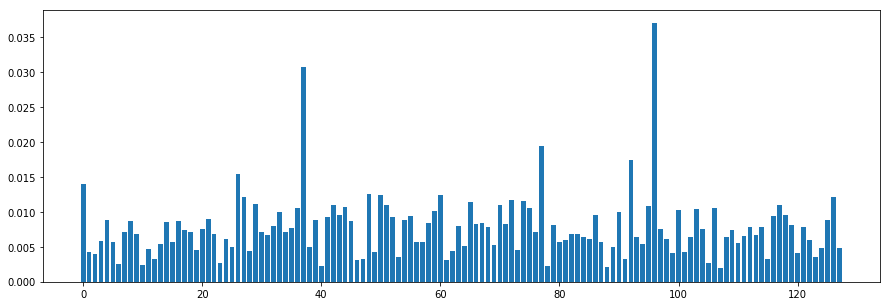

Train Epoch: 441 [0/2057 (0%)]	Loss: 3091.6003
====> Epoch: 441 Average train loss: 0.25418
====> Epoch: 441 Average test loss: 0.21534
Train Epoch: 442 [0/2057 (0%)]	Loss: 3021.4849
====> Epoch: 442 Average train loss: 0.25067
====> Epoch: 442 Average test loss: 0.21792
Train Epoch: 443 [0/2057 (0%)]	Loss: 3163.8032
====> Epoch: 443 Average train loss: 0.24897
====> Epoch: 443 Average test loss: 0.21798
Train Epoch: 444 [0/2057 (0%)]	Loss: 3184.0869
====> Epoch: 444 Average train loss: 0.24880
====> Epoch: 444 Average test loss: 0.21647
Train Epoch: 445 [0/2057 (0%)]	Loss: 3203.0132
====> Epoch: 445 Average train loss: 0.25016
====> Epoch: 445 Average test loss: 0.21683
Train Epoch: 446 [0/2057 (0%)]	Loss: 2990.8804
====> Epoch: 446 Average train loss: 0.25022
====> Epoch: 446 Average test loss: 0.21791
Train Epoch: 447 [0/2057 (0%)]	Loss: 3392.1289
====> Epoch: 447 Average train loss: 0.24861
====> Epoch: 447 Average test loss: 0.21742
Train Epoch: 448 [0/2057 (0%)]	Loss: 3242.7012
=

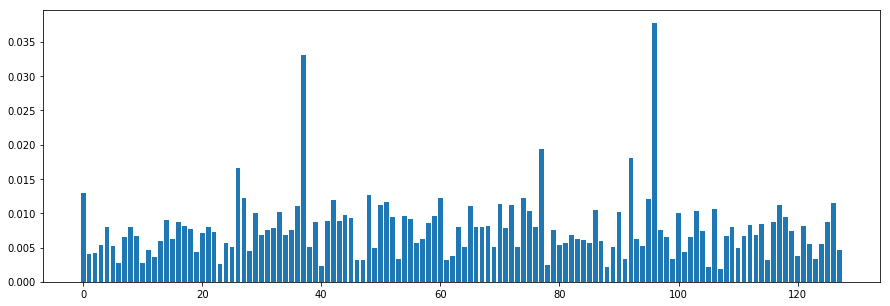

Train Epoch: 451 [0/2057 (0%)]	Loss: 2762.3538
====> Epoch: 451 Average train loss: 0.24932
====> Epoch: 451 Average test loss: 0.21776
Train Epoch: 452 [0/2057 (0%)]	Loss: 3111.9556
====> Epoch: 452 Average train loss: 0.24852
====> Epoch: 452 Average test loss: 0.21858
Train Epoch: 453 [0/2057 (0%)]	Loss: 3072.3455
====> Epoch: 453 Average train loss: 0.25094
====> Epoch: 453 Average test loss: 0.21809
Train Epoch: 454 [0/2057 (0%)]	Loss: 2925.9475
====> Epoch: 454 Average train loss: 0.25350
====> Epoch: 454 Average test loss: 0.21923
Train Epoch: 455 [0/2057 (0%)]	Loss: 2678.4370
====> Epoch: 455 Average train loss: 0.24941
====> Epoch: 455 Average test loss: 0.21643
Train Epoch: 456 [0/2057 (0%)]	Loss: 2872.1907
====> Epoch: 456 Average train loss: 0.24957
====> Epoch: 456 Average test loss: 0.21467
Train Epoch: 457 [0/2057 (0%)]	Loss: 2802.0645
====> Epoch: 457 Average train loss: 0.25000
====> Epoch: 457 Average test loss: 0.22027
Train Epoch: 458 [0/2057 (0%)]	Loss: 2811.8062
=

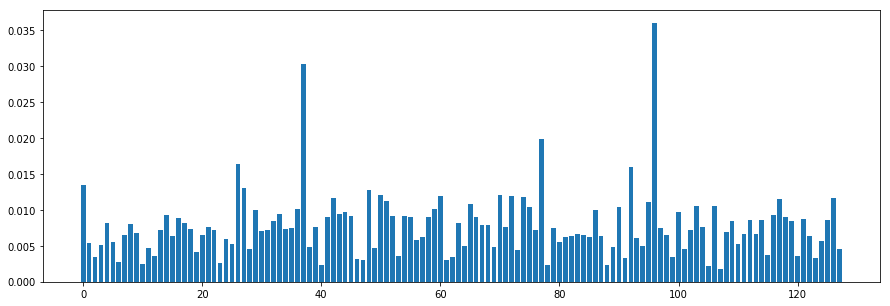

Train Epoch: 461 [0/2057 (0%)]	Loss: 3345.3269
====> Epoch: 461 Average train loss: 0.25212
====> Epoch: 461 Average test loss: 0.21658
Train Epoch: 462 [0/2057 (0%)]	Loss: 3133.0679
====> Epoch: 462 Average train loss: 0.24887
====> Epoch: 462 Average test loss: 0.21605
Train Epoch: 463 [0/2057 (0%)]	Loss: 3096.1628
====> Epoch: 463 Average train loss: 0.24862
====> Epoch: 463 Average test loss: 0.22094
Train Epoch: 464 [0/2057 (0%)]	Loss: 2590.9617
====> Epoch: 464 Average train loss: 0.24884
====> Epoch: 464 Average test loss: 0.21806
Train Epoch: 465 [0/2057 (0%)]	Loss: 3009.6367
====> Epoch: 465 Average train loss: 0.25168
====> Epoch: 465 Average test loss: 0.21700
Train Epoch: 466 [0/2057 (0%)]	Loss: 3209.8887
====> Epoch: 466 Average train loss: 0.25215
====> Epoch: 466 Average test loss: 0.22090
Train Epoch: 467 [0/2057 (0%)]	Loss: 3097.4448
====> Epoch: 467 Average train loss: 0.25071
====> Epoch: 467 Average test loss: 0.21588
Train Epoch: 468 [0/2057 (0%)]	Loss: 2957.8894
=

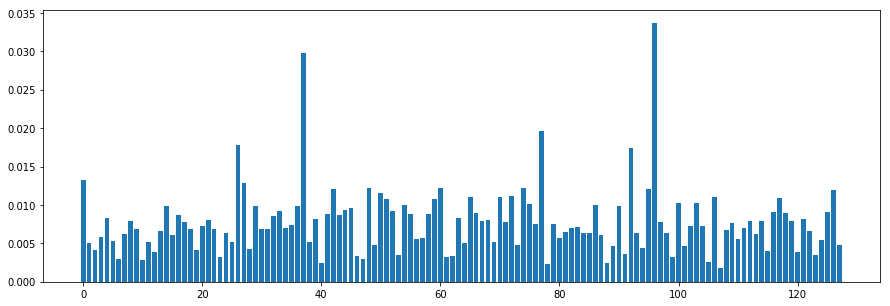

Train Epoch: 471 [0/2057 (0%)]	Loss: 3328.8481
====> Epoch: 471 Average train loss: 0.24973
====> Epoch: 471 Average test loss: 0.21763
Train Epoch: 472 [0/2057 (0%)]	Loss: 3079.2883
====> Epoch: 472 Average train loss: 0.25139
====> Epoch: 472 Average test loss: 0.21733
Train Epoch: 473 [0/2057 (0%)]	Loss: 3010.7690
====> Epoch: 473 Average train loss: 0.24862
====> Epoch: 473 Average test loss: 0.21649
Train Epoch: 474 [0/2057 (0%)]	Loss: 2513.1323
====> Epoch: 474 Average train loss: 0.24832
====> Epoch: 474 Average test loss: 0.21509
Train Epoch: 475 [0/2057 (0%)]	Loss: 3058.9517
====> Epoch: 475 Average train loss: 0.25019
====> Epoch: 475 Average test loss: 0.21549
Train Epoch: 476 [0/2057 (0%)]	Loss: 3016.0552
====> Epoch: 476 Average train loss: 0.24902
====> Epoch: 476 Average test loss: 0.21646
Train Epoch: 477 [0/2057 (0%)]	Loss: 2886.0396
====> Epoch: 477 Average train loss: 0.25054
====> Epoch: 477 Average test loss: 0.21608
Train Epoch: 478 [0/2057 (0%)]	Loss: 3303.0933
=

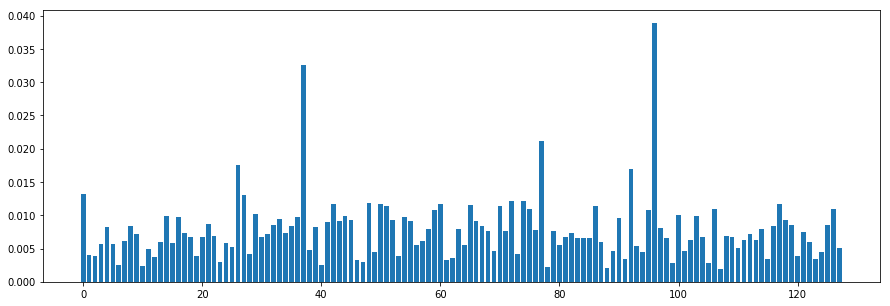

Train Epoch: 481 [0/2057 (0%)]	Loss: 3057.7444
====> Epoch: 481 Average train loss: 0.24982
====> Epoch: 481 Average test loss: 0.21833
Train Epoch: 482 [0/2057 (0%)]	Loss: 3109.0898
====> Epoch: 482 Average train loss: 0.24692
====> Epoch: 482 Average test loss: 0.21535
Train Epoch: 483 [0/2057 (0%)]	Loss: 3013.2363
====> Epoch: 483 Average train loss: 0.24858
====> Epoch: 483 Average test loss: 0.21574
Train Epoch: 484 [0/2057 (0%)]	Loss: 2912.7646
====> Epoch: 484 Average train loss: 0.25169
====> Epoch: 484 Average test loss: 0.21853
Train Epoch: 485 [0/2057 (0%)]	Loss: 2858.3784
====> Epoch: 485 Average train loss: 0.25035
====> Epoch: 485 Average test loss: 0.21805
Train Epoch: 486 [0/2057 (0%)]	Loss: 2784.9224
====> Epoch: 486 Average train loss: 0.24772
====> Epoch: 486 Average test loss: 0.21746
Train Epoch: 487 [0/2057 (0%)]	Loss: 2936.2974
====> Epoch: 487 Average train loss: 0.25021
====> Epoch: 487 Average test loss: 0.21663
Train Epoch: 488 [0/2057 (0%)]	Loss: 2876.8857
=

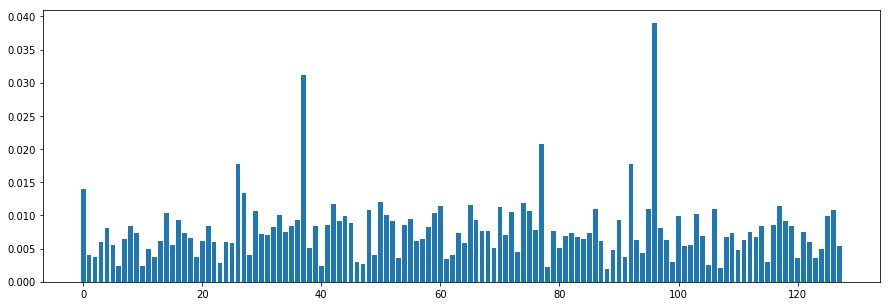

Train Epoch: 491 [0/2057 (0%)]	Loss: 2896.8652
====> Epoch: 491 Average train loss: 0.25088
====> Epoch: 491 Average test loss: 0.21789
Train Epoch: 492 [0/2057 (0%)]	Loss: 2980.1123
====> Epoch: 492 Average train loss: 0.24848
====> Epoch: 492 Average test loss: 0.21527
Train Epoch: 493 [0/2057 (0%)]	Loss: 2873.6482
====> Epoch: 493 Average train loss: 0.24941
====> Epoch: 493 Average test loss: 0.21687
Train Epoch: 494 [0/2057 (0%)]	Loss: 2817.1526
====> Epoch: 494 Average train loss: 0.24852
====> Epoch: 494 Average test loss: 0.21761
Train Epoch: 495 [0/2057 (0%)]	Loss: 3017.9619
====> Epoch: 495 Average train loss: 0.25022
====> Epoch: 495 Average test loss: 0.21687
Train Epoch: 496 [0/2057 (0%)]	Loss: 2936.6926
====> Epoch: 496 Average train loss: 0.25038
====> Epoch: 496 Average test loss: 0.21890
Train Epoch: 497 [0/2057 (0%)]	Loss: 2871.9475
====> Epoch: 497 Average train loss: 0.24945
====> Epoch: 497 Average test loss: 0.21820
Train Epoch: 498 [0/2057 (0%)]	Loss: 3023.8169
=

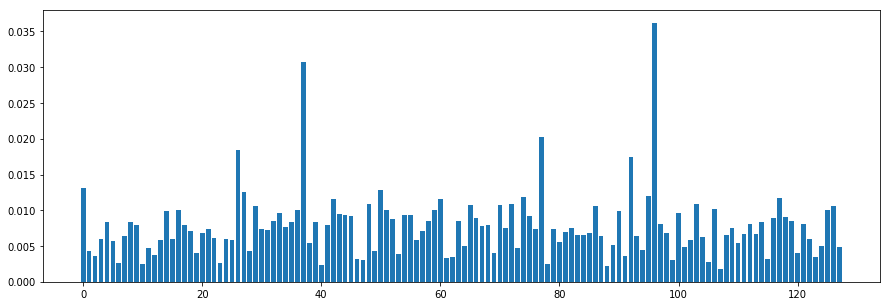

--- 2081.113174200058 seconds ---
Minimal train/testing losses are 1.0000 and 10.0000 with index 458



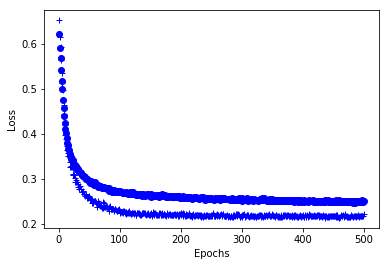

In [11]:
epochs = 500
start_time = time.time()

for epoch in range(1, epochs + 1):
    #scheduler.step()
    
    train_loss = train(epoch)
    test_loss, _, _ = test(epoch)
    #save_model(test_loss, train_loss)
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    
print("--- %s seconds ---" % (time.time() - start_time))
print('Minimal train/testing losses are {:.4f} and {:.4f} with index {}\n'
    .format(cur_train_loss, best_val_loss, test_loss_history.index(min(test_loss_history))))

# plot train and test loss against epochs
plt.figure(1)
epoch_axis = range(1, len(train_loss_history) + 1)
plt.plot(epoch_axis, train_loss_history, 'bo')
plt.plot(epoch_axis, test_loss_history, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
# data = next(iter(train_loader))
# data = data.to(gpu)
# out, _, _ = model(data)
# model.load_state_dict(torch.load('./cae_models/spk_vq_vae_easy1_N16.pt'))

<Figure size 432x288 with 0 Axes>

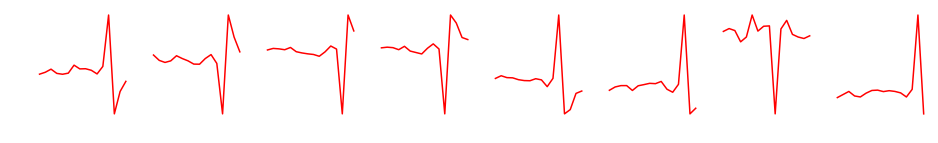

In [19]:
# plt.figure()
# n_row, n_col = 8, 8
# f, axarr = plt.subplots(n_row, n_col, figsize=(n_col*1.5, n_row*1.5))
# cur_ker = model.embed.weight.data.cpu().numpy()
# for i in range(n_row):
#     for j in range(n_col):
#         axarr[i, j].plot(cur_ker[i*n_row+j], 'r')
#         axarr[i, j].axis('off')
# plt.show()

#model.load_state_dict(torch.load('./spk_vq_vae_temp.pt'))
#torch.save(model.state_dict(), './cae_models/spk_vq_vae_hc1_vq{}_N{}.pt'.format(vq_num, param_resnet_v2[2]))
#torch.save(model.state_dict(), './cae_models/spk_vq_vae_neuropixels_c15r_vq{}_N{}.pt'.format(vq_num, param_resnet_v2[2]))
#torch.save(model.state_dict(), './cae_models/spk_vq_vae_waveclus_vq{}_N{}.pt'.format(vq_num, param_resnet_v2[2]))

embed_idx = np.argsort(model.embed_freq)
embed_sort = model.dict_val.data.cpu().numpy()[embed_idx]

plt.figure()
n_row, n_col = 1, 8
f, axarr = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(8):
    axarr[i].plot(embed_sort[i], 'r')
    axarr[i].axis('off')
plt.show()

In [14]:
# %% spike recon
train_mean, train_std, _ = helper.param_for_recon()
train_mean, train_std = torch.from_numpy(train_mean), torch.from_numpy(train_std)
_, val_spks, test_spks = test(9)

# val_spks = val_spks.numpy()
# test_spks = test_spks.numpy()

# calculate compression ratio
vq_freq = model.embed_freq / sum(model.embed_freq)
vq_freq = vq_freq[vq_freq != 0]
vq_log2 = np.log2(vq_freq)
bits = -sum(np.multiply(vq_freq, vq_log2))
cr = spk_ch * spk_dim * 16 / (param_resnet_v2[2] * bits)
print('compression ratio is {:.2f} with {:.2f}-bit.'.format(cr, bits))

====> Epoch: 9 Average test loss: 0.21909
compression ratio is 37.92 with 6.75-bit.


In [15]:
#xx = np.linalg.norm(test_spks_new, axis=1)
# def cal_sndr(org_data, recon_data):
#     org_norm = np.linalg.norm(org_data, axis=1)
#     err_norm = np.linalg.norm(org_data-recon_data, axis=1)
#     return np.mean(20*np.log10(org_norm / err_norm))

recon_spks = (val_spks * train_std + train_mean).view(-1, spk_dim)
test_spks_v2 = (test_spks * train_std + train_mean).view(-1, spk_dim)

recon_err = torch.norm(recon_spks-test_spks_v2, p=2, dim=1) / torch.norm(test_spks_v2, p=2, dim=1)

print('mean of recon_err is {:.4f}'.format(torch.mean(recon_err)))
print('std of recon_err is {:.4f}'.format(torch.std(recon_err)))

mean of recon_err is 0.2667
std of recon_err is 0.0821


In [16]:
# %% spike visualization for 3-d inputs
recon_spks_new = recon_spks.numpy()
test_spks_new = test_spks_v2.numpy()

def cal_sndr(org_data, recon_data):
    org_norm = np.linalg.norm(org_data, axis=1)
    err_norm = np.linalg.norm(org_data-recon_data, axis=1)
    return np.mean(20*np.log10(org_norm / err_norm)), np.std(20*np.log10(org_norm / err_norm))

cur_sndr, sndr_std = cal_sndr(test_spks_new, recon_spks_new)
print('SNDR is {:.4f} with std {:.4f}'.format(cur_sndr, sndr_std))

SNDR is 11.8879 with std 2.6918


<Figure size 432x288 with 0 Axes>

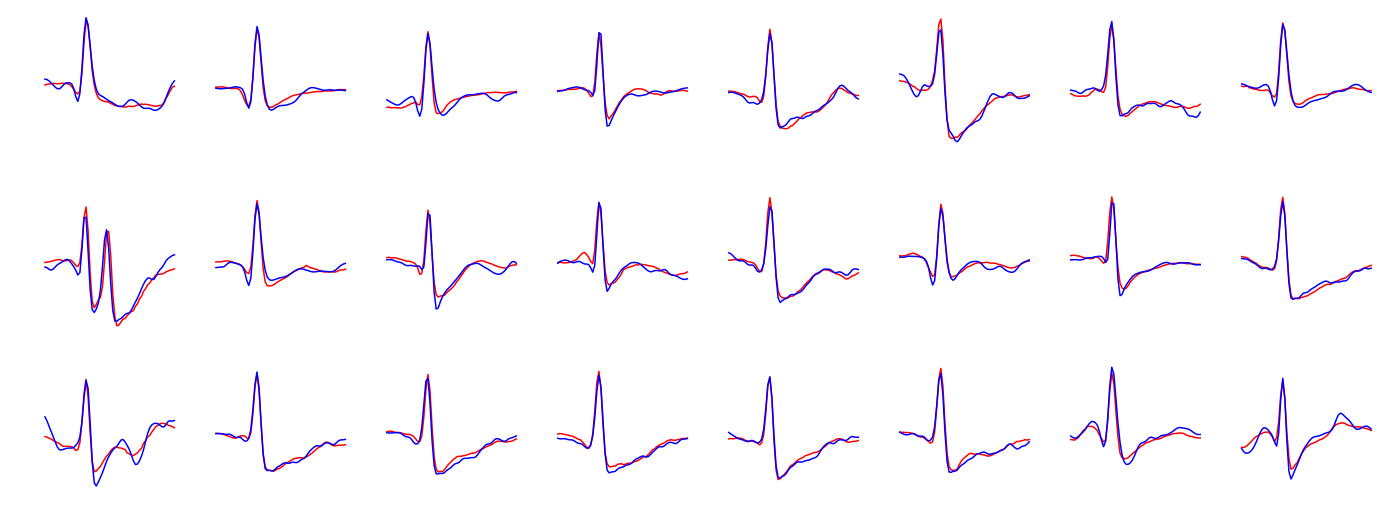

In [18]:
rand_val_idx = np.random.permutation(len(recon_spks_new))

plt.figure()
n_row, n_col = 3, 8
spks_to_show = test_spks_new[rand_val_idx[:n_row*n_col]]
ymax, ymin = np.amax(spks_to_show), np.amin(spks_to_show)
f, axarr = plt.subplots(n_row, n_col, figsize=(n_col*3, n_row*3))
for i in range(n_row):
    for j in range(n_col):
        axarr[i, j].plot(recon_spks_new[rand_val_idx[i*n_col+j]], 'r')
        axarr[i, j].plot(test_spks_new[rand_val_idx[i*n_col+j]], 'b')
        axarr[i, j].set_ylim([ymin*1.1, ymax*1.1])
        axarr[i, j].axis('off')
#plt.show()
#plt.savefig('waveclus_spks.eps', format='eps', dpi=600)